In [1]:
import pandas as pd
energy = '/content/energy_dataset.xlsx'
weather = '/content/weather_features.xlsx'

energy_df = pd.read_excel(energy)
weather_df = pd.read_excel(weather)

In [2]:
#drop the 'city_name' column.
weather_df = weather_df.drop(columns=['city_name'])

In [3]:
# Ensure categorical columns are strings
weather_df['weather_main'] = weather_df['weather_main'].astype(str)
weather_df['weather_description'] = weather_df['weather_description'].astype(str)
weather_df['weather_icon'] = weather_df['weather_icon'].astype(str)

In [4]:
weather_df = weather_df.groupby('dt_iso').agg({
    'temp':'mean',
    'temp_min':'mean',
    'temp_max':'mean',
    'humidity':'mean',
    'wind_speed':'mean',
    'pressure':'mean',
    'rain_1h':'mean',
    'rain_3h':'mean',
    'snow_3h':'mean',
    'clouds_all':'mean',
    'wind_deg':'mean',
    'weather_id':lambda x: x.mode()[0] if not x.empty else None,
    'weather_main':lambda x: x.mode()[0] if not x.empty else None, # Use a lambda function to apply mode to each group
    'weather_description':lambda x: x.mode()[0] if not x.empty else None, # Use a lambda function to apply mode to each group
    'weather_icon':lambda x: x.mode()[0] if not x.empty else None # Use a lambda function to apply mode to each group
}).reset_index()

In [5]:
merged_dataset = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')

#drop the 'dt_iso' column from the merge_data
merged_dataset=merged_dataset.drop(columns=['dt_iso'])

# converting datetime column back to the string
merged_dataset['time'] = merged_dataset['time'].astype(str)

In [6]:
print(merged_dataset.isnull().sum())

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [7]:
# FILL THE MISSING VALUES

merged_dataset=merged_dataset.fillna(method='ffill')

In [8]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 44 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35064 non-null  float64
 2   generation fossil brown coal/lignite         35064 non-null  float64
 3   generation fossil coal-derived gas           35064 non-null  float64
 4   generation fossil gas                        35064 non-null  float64
 5   generation fossil hard coal                  35064 non-null  float64
 6   generation fossil oil                        35064 non-null  float64
 7   generation fossil oil shale                  35064 non-null  float64
 8   generation fossil peat                       35064 non-null  float64
 9   generation geothermal                        35064 non-null  float64
 10

In [9]:
merged_dataset = merged_dataset.drop(columns=['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation hydro pumped storage aggregated','generation marine','generation wind offshore','forecast wind offshore eday ahead'])
merged_dataset.shape

(35064, 36)

In [10]:
# Handle missing values using different techniques
merged_dataset = merged_dataset.ffill().bfill()
print(merged_dataset.isnull().sum())

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual        

In [11]:
# FINDING OUTLIERS AND REMOVE THEM
import scipy.stats as stats
import numpy as np
numerical_cols = merged_dataset.select_dtypes(include=np.number).columns
z_scores = stats.zscore(merged_dataset[numerical_cols])
column_names = numerical_cols
outliers = np.where(np.abs(z_scores) > 3) #np.where function returns a tuple where each element is an array of indices where the condition is true along each axis.
outliers_count = {}
# Print the number of outliers for each column
for i in range(z_scores.shape[1]):
    num_outliers = len(outliers[0][outliers[1] == i])  # Count the number of rows for each column. 0 means row index, 1 means column index.
    outliers_count[column_names[i]] = num_outliers
    print(f"Number of outliers in column '{column_names[i]}': {num_outliers}")

Number of outliers in column 'generation biomass': 5
Number of outliers in column 'generation fossil brown coal/lignite': 0
Number of outliers in column 'generation fossil gas': 491
Number of outliers in column 'generation fossil hard coal': 0
Number of outliers in column 'generation fossil oil': 27
Number of outliers in column 'generation hydro pumped storage consumption': 1005
Number of outliers in column 'generation hydro run-of-river and poundage': 0
Number of outliers in column 'generation hydro water reservoir': 194
Number of outliers in column 'generation nuclear': 53
Number of outliers in column 'generation other': 0
Number of outliers in column 'generation other renewable': 7
Number of outliers in column 'generation solar': 0
Number of outliers in column 'generation waste': 106
Number of outliers in column 'generation wind onshore': 113
Number of outliers in column 'forecast solar day ahead': 0
Number of outliers in column 'forecast wind onshore day ahead': 128
Number of outli

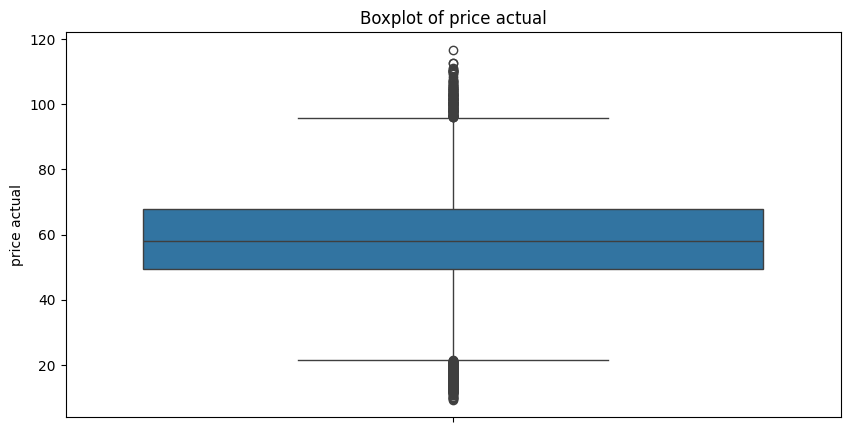


Number of Outliers in price actual: 699


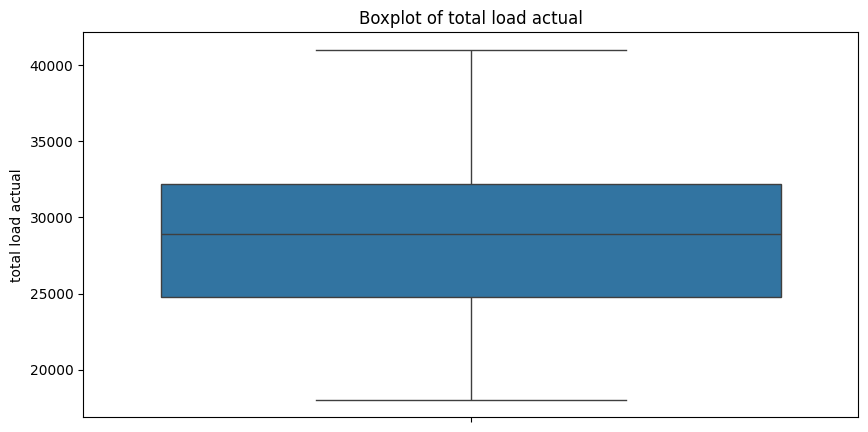


Number of Outliers in total load actual: 0


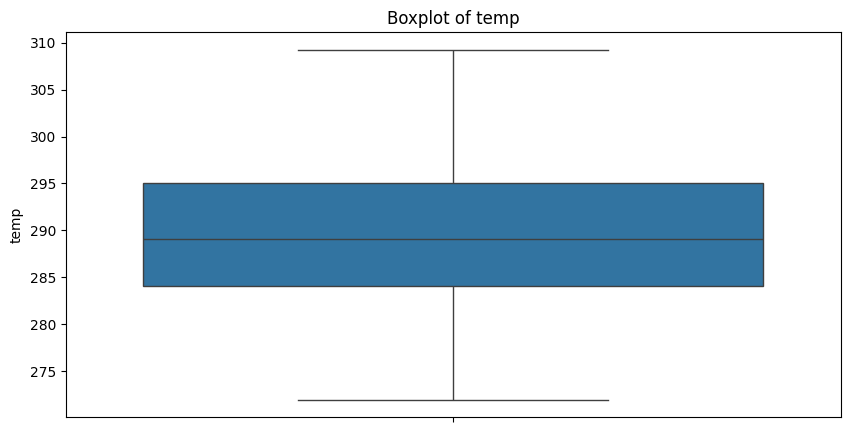


Number of Outliers in temp: 0


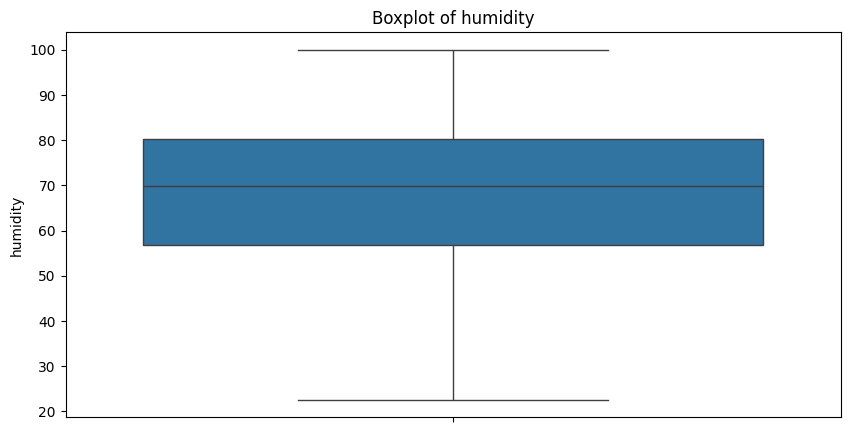


Number of Outliers in humidity: 0


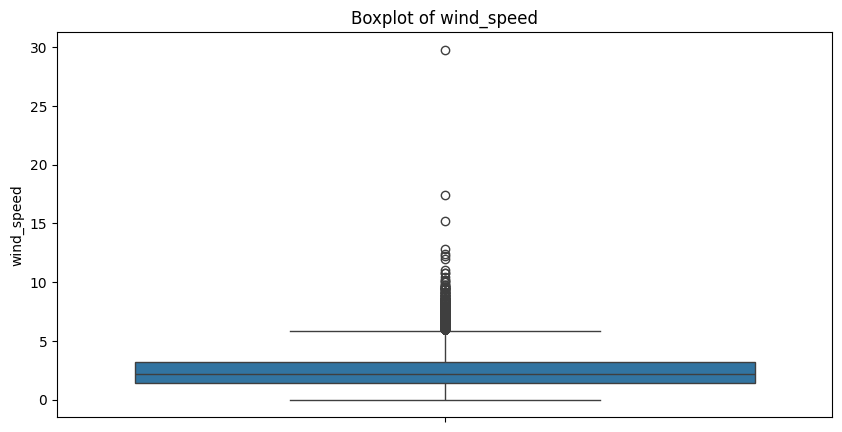


Number of Outliers in wind_speed: 830


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_check = ['price actual', 'total load actual', 'temp', 'humidity', 'wind_speed']

for column in columns_to_check:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=merged_dataset, y=column)
    plt.title(f'Boxplot of {column}')
    plt.show()

    # Calculate IQR
    Q1 = merged_dataset[column].quantile(0.25)
    Q3 = merged_dataset[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = merged_dataset[(merged_dataset[column] < lower_bound) | (merged_dataset[column] > upper_bound)]
    print(f"\nNumber of Outliers in {column}: {outliers.shape[0]}")

In [28]:
Q1 = merged_dataset['price actual'].quantile(0.25)
Q3 = merged_dataset['price actual'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [29]:
#replace outliers with NaN
merged_dataset['price actual interpolation'] = merged_dataset['price actual'].apply(
lambda x: None if x < lower_bound or x > upper_bound else x)
merged_dataset['price actual interpolation'].isnull().sum()

699

In [30]:
#Interpolate to replace the NaN values
merged_dataset['price actual interpolation'] = merged_dataset['price actual interpolation'].interpolate()
merged_dataset['price actual interpolation'].isnull().sum()

0

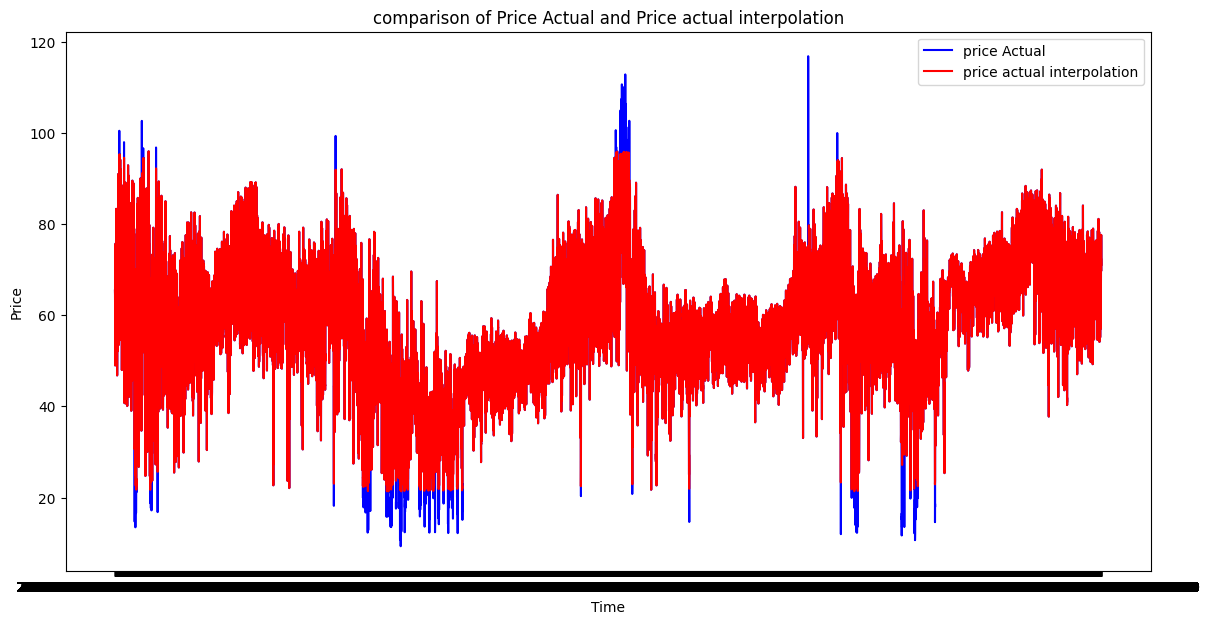

In [ ]:
#Compare after removing the outliers
plt.figure(figsize=(14,7))

#ploting the price actual value
plt.plot(merged_dataset['time'],merged_dataset['price actual'], label='price Actual', color='blue', linestyle='-')

#plot the 'price actual interpolation' values
plt.plot(merged_dataset['time'],merged_dataset['price actual interpolation'], label='price actual interpolation', color='red', linestyle='-')

plt.title('comparison of Price Actual and Price actual interpolation')
plt.xlabel('Time')
plt.ylabel('Price')

plt.legend()

plt.show()

In [12]:
#ensure 'time' column is in datetime format
merged_dataset['time'] = pd.to_datetime(merged_dataset['time'], utc=True).dt.tz_convert(None)

In [13]:
#Extract the day of the week from the 'time' column

merged_dataset['day_of_week'] = merged_dataset['time'].dt.dayofweek

#new column for indicating whether
merged_dataset['is_weekday'] = merged_dataset['day_of_week'].apply(lambda x: '0' if x >= 5 else '1')

In [14]:
merged_dataset['hour'] = merged_dataset['time'].dt.hour

#calculate the average electricity demand for each hour across all days
hourly_avg_demand = merged_dataset.groupby('hour')['total load actual'].mean().reset_index()
hourly_avg_demand.columns = ['hour' , 'hourly_avg_demand']

merged_dataset = pd.merge(merged_dataset , hourly_avg_demand, on='hour', how='left')

#Creating peak/off Peak column
merged_dataset['peak|off-peak'] =merged_dataset.apply(lambda row: 1 if row ['total load actual'] > row['hourly_avg_demand'] else 0, axis=1)

In [15]:
# Ensure the 'time' column is in datetime format
merged_dataset['time'] = pd.to_datetime(merged_dataset['time'], utc=True).dt.tz_convert(None)

# Create new columns for each month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

for month_index, month in enumerate(months, start=1):
    merged_dataset[month] = (merged_dataset['time'].dt.month == month_index).astype(int)

In [16]:
#coverting the datetime to hr months and days
merged_dataset['time'] = pd.to_datetime(merged_dataset['time'], format='%Y/%m/%d %H:%M:%S',errors='coerce')
#dividing the time to month day weekday weekend
merged_dataset['month'] = merged_dataset['time'].dt.month
merged_dataset['day'] = merged_dataset['time'].dt.day
merged_dataset['weekday'] = merged_dataset['time'].dt.day_name()
merged_dataset['weekend'] = merged_dataset['time'].dt.weekday >= 5
merged_dataset.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,July,August,September,October,November,December,month,day,weekday,weekend
0,2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0,0,0,0,0,1,12,31,Wednesday,False
1,2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0,0,0,0,0,0,1,1,Thursday,False
2,2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0,0,0,0,0,0,1,1,Thursday,False
3,2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0,0,0,0,0,0,1,1,Thursday,False
4,2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0,0,0,0,0,0,1,1,Thursday,False


In [17]:
correlation_matrix = merged_dataset[['price actual','temp', 'wind_speed', 'pressure', 'humidity', 'clouds_all', 'total load actual']].corr()

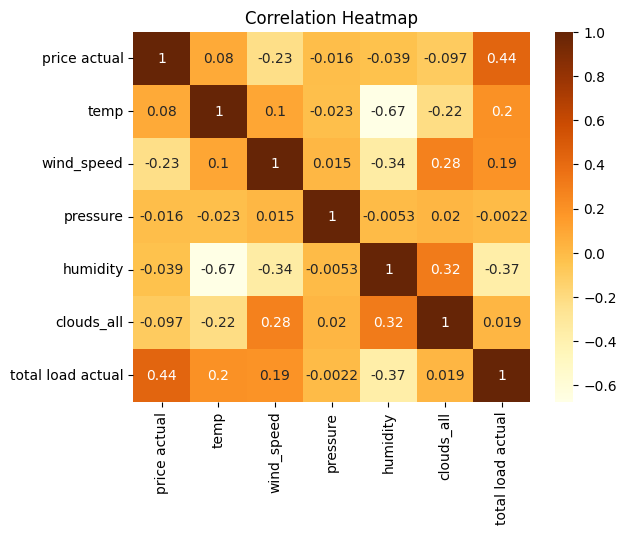

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr')
plt.title("Correlation Heatmap")
plt.show()

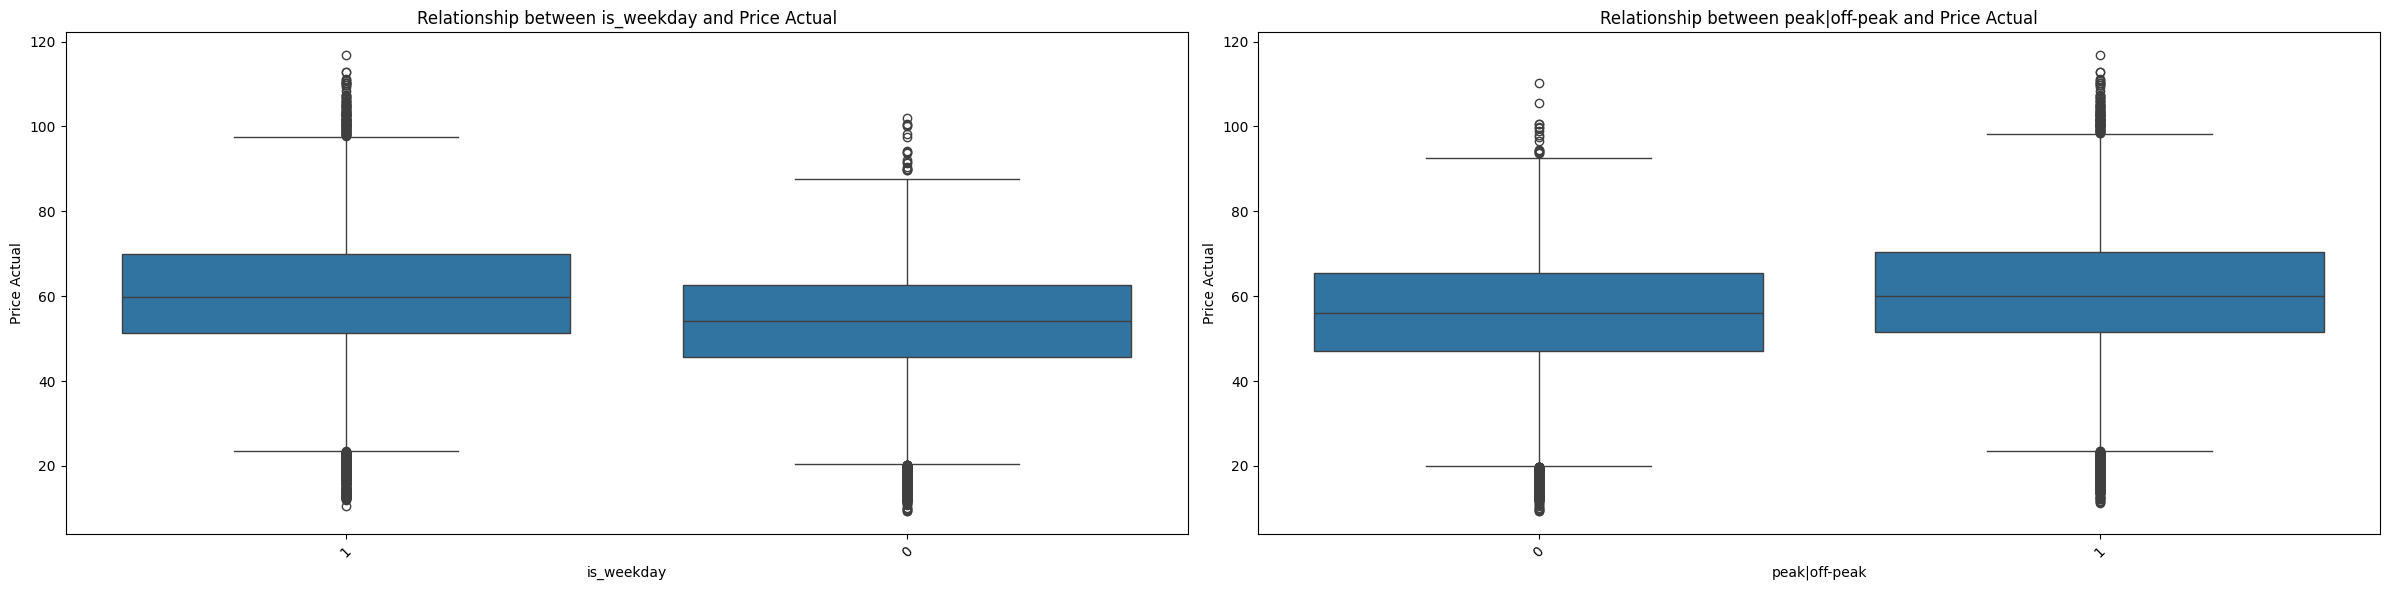

In [19]:
# Box plots for categorical features
categorical_features = ['is_weekday', 'peak|off-peak']

fig, axes = plt.subplots(1, len(categorical_features), figsize=(12 * len(categorical_features), 6))

for i, feature in enumerate(categorical_features):
    sns.boxplot(data=merged_dataset, x=feature, y='price actual', ax=axes[i])
    axes[i].set_title(f'Relationship between {feature} and Price Actual')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price Actual')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

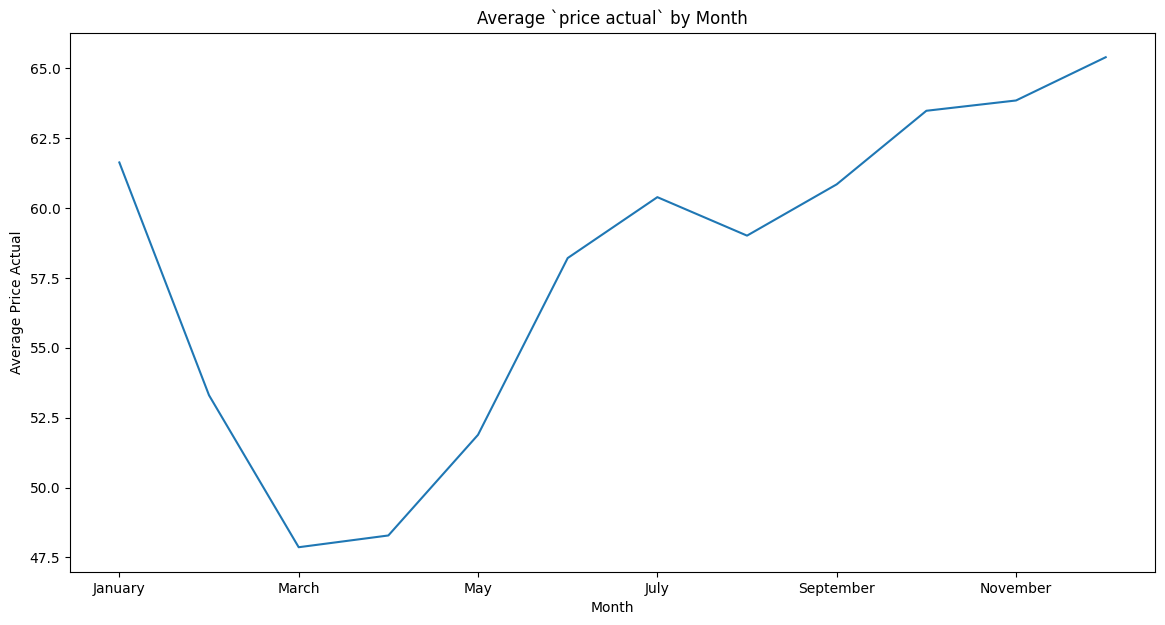

In [20]:
# Extract month and calculate average price actual for each month
monthly_avg_price = merged_dataset.groupby(merged_dataset['time'].dt.month_name())['price actual'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November', 'December'])

plt.figure(figsize=(14, 7))
monthly_avg_price.plot(kind='line')

plt.title('Average `price actual` by Month')
plt.xlabel('Month')
plt.ylabel('Average Price Actual')
plt.show()

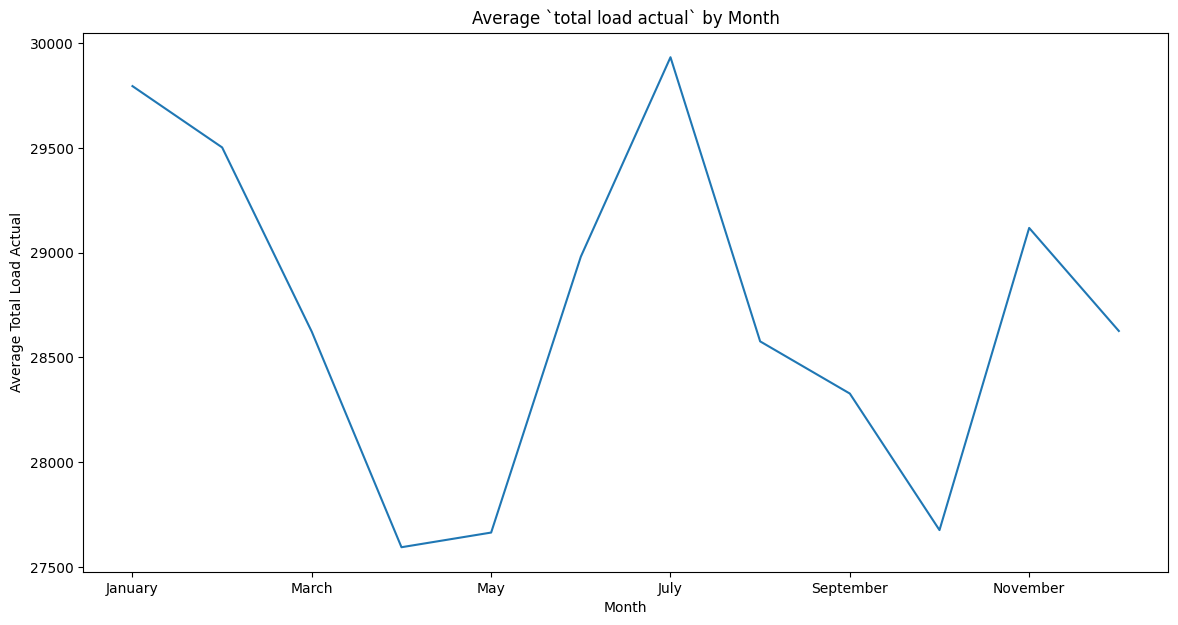

In [21]:
# Extract month and calculate average total load actual for each month
monthly_avg_load = merged_dataset.groupby(merged_dataset['time'].dt.month_name())['total load actual'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November', 'December'])

# Set plot size
plt.figure(figsize=(14, 7))

# Create a line plot
monthly_avg_load.plot(kind='line')

# Add titles and labels
plt.title('Average `total load actual` by Month')
plt.xlabel('Month')
plt.ylabel('Average Total Load Actual')

# Display the plot
plt.show()

Number of positive correlations for total load actual: 34
Columns with correlation greater than 0.0 for total load actual:
weather_id                                    0.004275
June                                          0.018526
clouds_all                                    0.019108
rain_1h                                       0.021264
November                                      0.027507
forecast wind onshore day ahead               0.037409
generation wind onshore                       0.039788
February                                      0.050944
January                                       0.073065
generation waste                              0.077163
July                                          0.082244
generation biomass                            0.083438
generation nuclear                            0.085803
generation other                              0.100768
generation hydro run-of-river and poundage    0.118340
generation other renewable                    0.1809

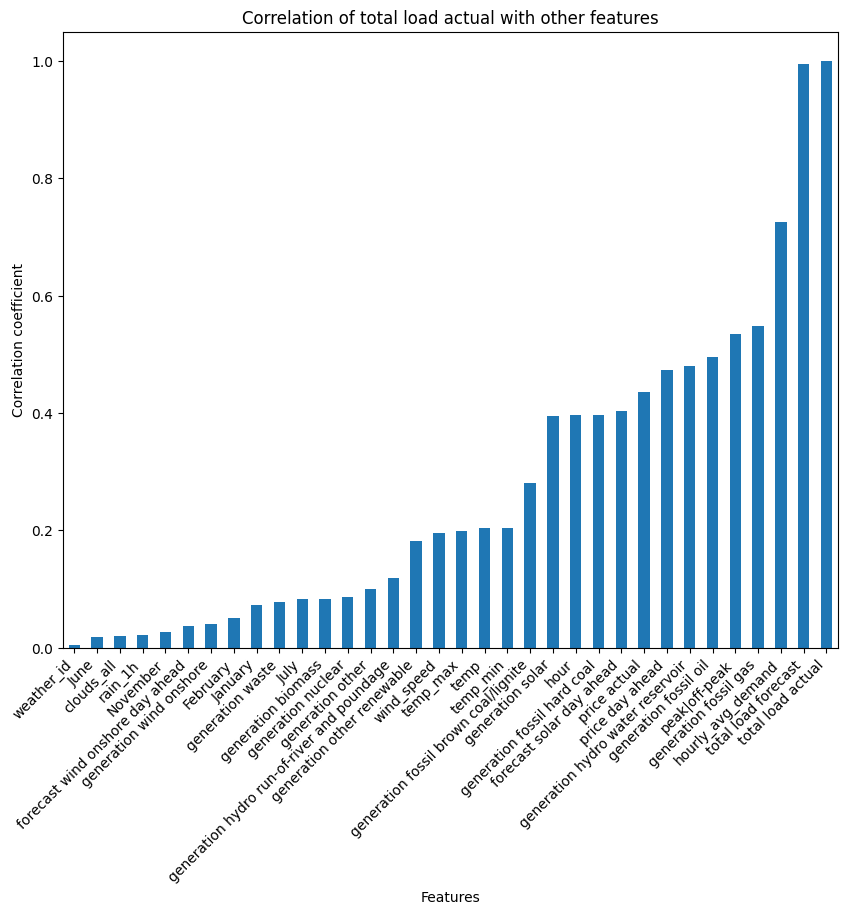

Number of positive correlations for price actual: 33
Columns with correlation greater than 0.0 for price actual:
June                                    0.006940
snow_3h                                 0.014884
August                                  0.024270
day                                     0.026703
weather_id                              0.037960
July                                    0.053781
temp_max                                0.061787
September                               0.062486
generation hydro water reservoir        0.071830
temp                                    0.080356
January                                 0.080405
temp_min                                0.093519
generation solar                        0.098530
generation other                        0.099875
forecast solar day ahead                0.101402
October                                 0.120049
November                                0.125683
generation biomass                      0.142688
Decem

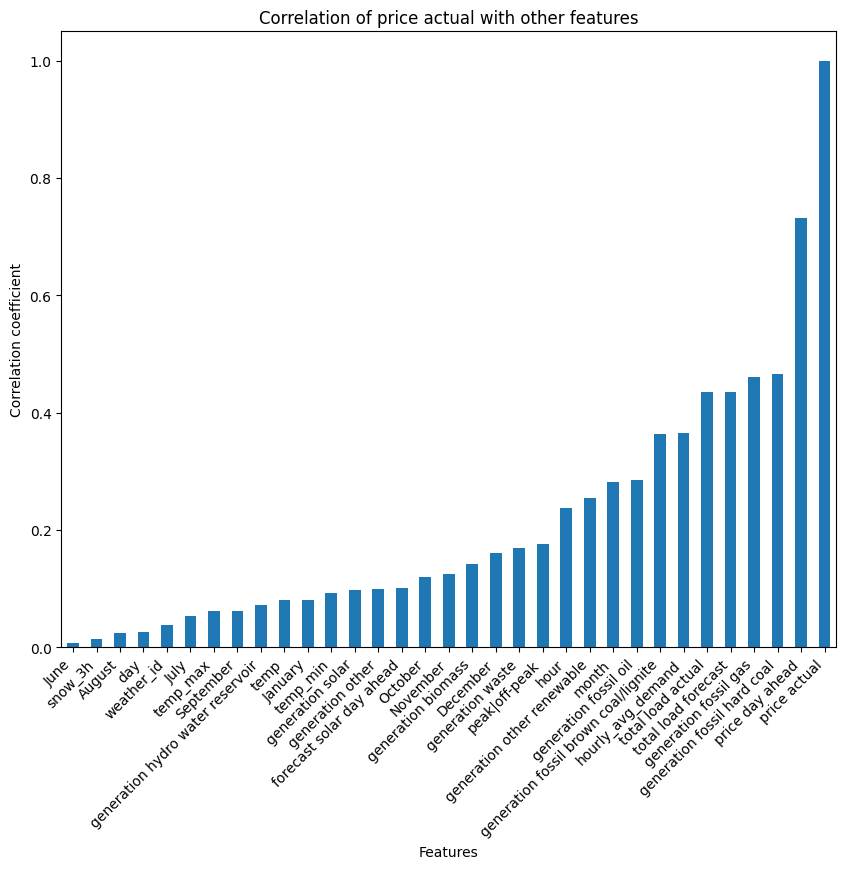

In [22]:
# Define the target columns
target_columns = ['total load actual', 'price actual']

for target_column in target_columns:
    # Select only numeric columns for correlation calculation
    numeric_columns = merged_dataset.select_dtypes(include=['number'])

    # Calculate correlations of the target column with other numeric columns
    correlations = numeric_columns.corr()[target_column].sort_values()

    # Filter out correlations greater than 0.0
    positive_correlations = correlations[correlations > 0.0]

    # Count the number of positive correlations
    b = positive_correlations.count()
    print(f'Number of positive correlations for {target_column}:', b)

    # Print the columns with correlations greater than 0.0
    print(f'Columns with correlation greater than 0.0 for {target_column}:')
    print(positive_correlations)

    # Plot the correlations
    plt.figure(figsize=(8, 8))
    positive_correlations.plot(kind='bar')
    plt.title(f'Correlation of {target_column} with other features')
    plt.xlabel('Features')
    plt.ylabel('Correlation coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
# Modelling

In [31]:
# Prepare the data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_l = merged_dataset[['hourly_avg_demand', 'generation fossil gas', 'peak|off-peak',
                 'generation fossil oil', 'generation hydro water reservoir', 'price day ahead',
                 'price actual interpolation', 'price actual', 'forecast solar day ahead', 'hour',
                 'generation solar', 'generation fossil brown coal/lignite', 'generation other',
                 'generation hydro run-of-river and poundage', 'generation other renewable',
                 'wind_speed', 'temp_max', 'temp','July','January','February','November']]
y_l = merged_dataset['total load actual']

# Split the data into training and testing sets
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled_l = scaler.fit_transform(X_train_l)
X_test_scaled_l = scaler.transform(X_test_l)

In [32]:
#Prepare dependent and independent veariable
X_p = merged_dataset[[
    'snow_3h', 'temp_max', 'weather_id', 'generation hydro water reservoir', 'temp', 'temp_min',
    'generation solar', 'generation other', 'forecast solar day ahead', 'generation biomass',
    'generation waste', 'peak|off-peak', 'hour', 'generation other renewable', 'month',
    'generation fossil oil', 'generation fossil brown coal/lignite', 'hourly_avg_demand',
    'total load actual', 'generation fossil gas', 'generation fossil hard coal', 'December',
    'October','November','September'
]]
y_p = merged_dataset['price actual']

# Split the data into training and testing sets
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled_p = scaler.fit_transform(X_train_p)
X_test_scaled_p = scaler.transform(X_test_p)

In [ ]:
# SIMPLE LINEAR REGRESSION FOR LOAD

In [33]:
# Initialize the model
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_lr_l = lr_model.predict(X_test_scaled_l)

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Calculate metrics
mse_lr_l = mean_squared_error(y_test_l, y_pred_lr_l)
r2_lr_l = r2_score(y_test_l, y_pred_lr_l)
mae_lr_l = mean_absolute_error(y_test_l, y_pred_lr_l)
rmse_lr_l = np.sqrt(mse_lr_l)
mape_lr_l = mean_absolute_percentage_error(y_test_l, y_pred_lr_l)

n = X_test_l.shape[0]
p = X_test_l.shape[1]
adjusted_r2_lr_l = 1 - ((1 - r2_lr_l) * (n - 1) / (n - p - 1))

print(f'Mean Squared Error (MSE): {mse_lr_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lr_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lr_l:.2f}')
print(f'R-squared (R^2): {r2_lr_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lr_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lr_l:.2f}%')

Mean Squared Error (MSE): 2544405.34
Root Mean Squared Error (RMSE): 1595.12
Mean Absolute Error (MAE): 1256.93
R-squared (R^2): 0.88
Adjusted R-squared: 0.88
Mean Absolute Percentage Error (MAPE): 0.04%


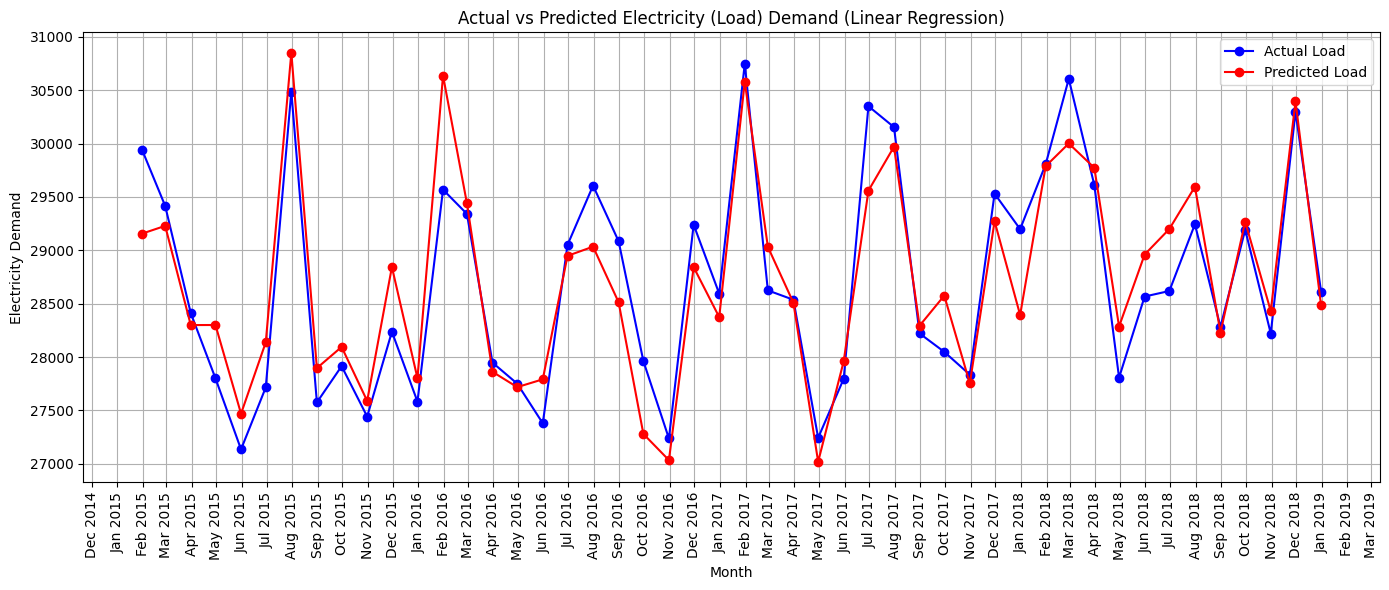

In [40]:
# Get the corresponding dates for the test set
test_indices = X_test_l.index

# Get the corresponding dates for the test set
test_dates = merged_dataset.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual Load': y_test_l, 'Predicted Load': y_pred_lr_l})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual Load'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted Load'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity (Load) Demand (Linear Regression)')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# SIMPLE LINEAR REGRESSION FOR TOTAL PRICE

In [35]:
# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_p, y_train_p)

# Make predictions
y_pred_lr_p = lr_model.predict(X_test_scaled_p)

# Calculate metrics
mse_lr_p = mean_squared_error(y_test_p, y_pred_lr_p)
r2_lr_p = r2_score(y_test_p, y_pred_lr_p)
mae_lr_p = mean_absolute_error(y_test_p, y_pred_lr_p)
rmse_lr_p = np.sqrt(mse_lr_p)
# Calculate adjusted R-squared
n = X_test_p.shape[0]
p = X_test_p.shape[1]
adjusted_r2_lr_p = 1 - ((1 - r2_lr_p) * (n - 1) / (n - p - 1))



mape_lr_p = mean_absolute_percentage_error(y_test_p, y_pred_lr_p)

# Print the results
print(f'Mean Squared Error (MSE): {mse_lr_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lr_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lr_p:.2f}')
print(f'R-squared (R^2): {r2_lr_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lr_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lr_p:.2f}%')

Mean Squared Error (MSE): 111.97
Root Mean Squared Error (RMSE): 10.58
Mean Absolute Error (MAE): 7.99
R-squared (R^2): 0.45
Adjusted R-squared: 0.45
Mean Absolute Percentage Error (MAPE): 0.17%


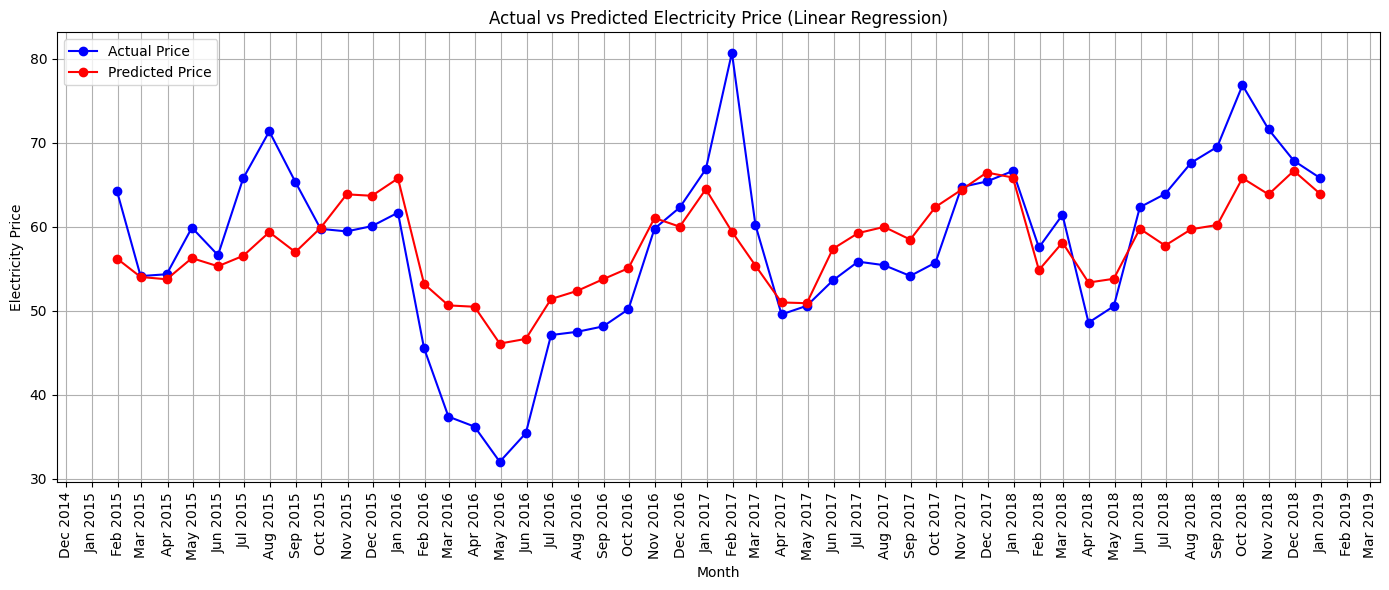

In [38]:
# Get the corresponding dates for the test set
test_indices_p = X_test_p.index

# Get the corresponding dates for the test set
test_dates_p = merged_dataset.loc[test_indices_p, 'time']

# Convert test_dates to datetime if not already
test_dates_p = pd.to_datetime(test_dates_p)

# Create a DataFrame with the dates, actual, and predicted values
results_df_p = pd.DataFrame({'Date': test_dates_p, 'Actual Price': y_test_p, 'Predicted Price': y_pred_lr_p})

# Set Date as the index
results_df_p.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_p = results_df_p.resample('M').mean()

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import the mdates module

plt.figure(figsize=(14, 6))
plt.plot(monthly_results_p.index, monthly_results_p['Actual Price'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_p.index, monthly_results_p['Predicted Price'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price (Linear Regression)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
#Random Forest without tuning for load

In [41]:
# Initialize the model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_rf_l = rf_model.predict(X_test_scaled_l)

# Calculate metrics
mse_rf_l = mean_squared_error(y_test_l, y_pred_rf_l)
r2_rf_l = r2_score(y_test_l, y_pred_rf_l)
mae_rf_l = mean_absolute_error(y_test_l, y_pred_rf_l)
rmse_rf_l = np.sqrt(mse_rf_l)
mape_rf_l = mean_absolute_percentage_error(y_test_l, y_pred_rf_l)

# Calculate adjusted R-squared
n = X_test_l.shape[0]
p = X_test_l.shape[1]
adjusted_r2_rf_l = 1 - ((1 - r2_rf_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nRandom Forest Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_l:.2f}')
print(f'R-squared (R²): {r2_rf_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_l:.2f}%')


Random Forest Model for `total load actual`:
Mean Squared Error (MSE): 1043239.76
Root Mean Squared Error (RMSE): 1021.39
Mean Absolute Error (MAE): 762.39
R-squared (R²): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 0.03%


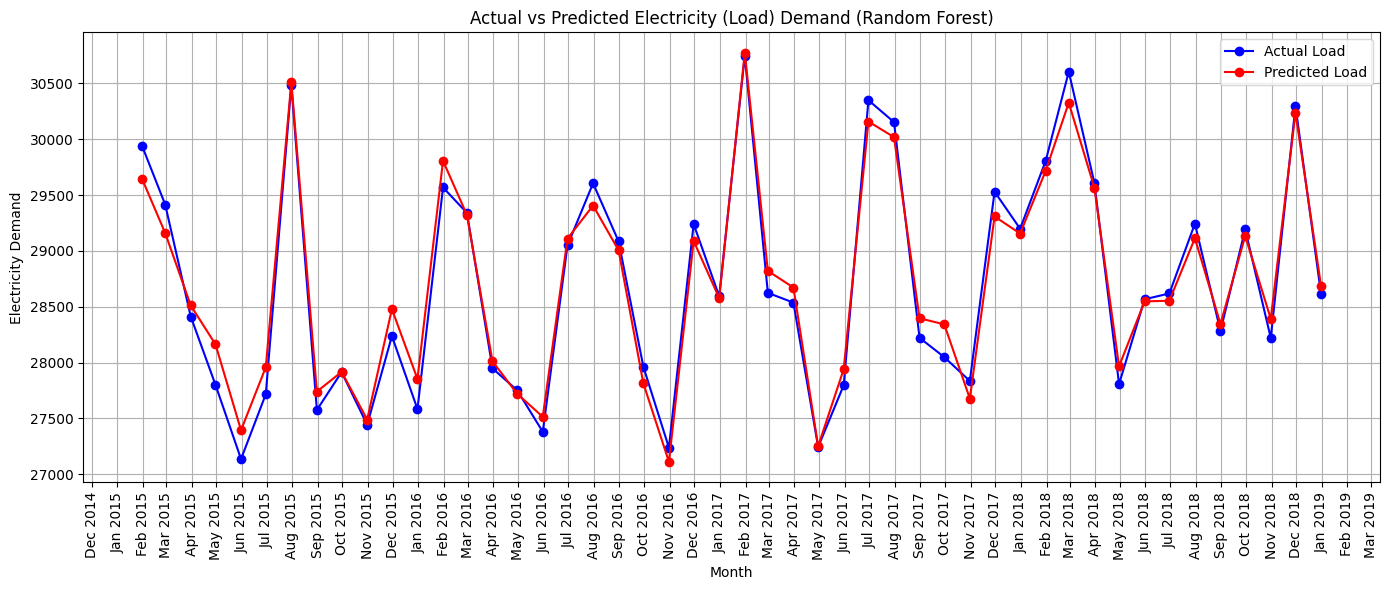

In [42]:
# Get the corresponding dates for the test set
test_indices = X_test_l.index

# Get the corresponding dates for the test set
test_dates = merged_dataset.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual Load': y_test_l, 'Predicted Load': y_pred_rf_l})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual Load'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted Load'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity (Load) Demand (Random Forest)')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# RANDOM FOREST FOR PRICE WITHOUT TUNING

In [43]:
# Initialize the model
rf_model_p = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model_p.fit(X_train_scaled_p.reshape(X_train_scaled_p.shape[0], -1), y_train_p)

# Make predictions
y_pred_rf_p = rf_model_p.predict(X_test_scaled_p.reshape(X_test_scaled_p.shape[0], -1))

# Calculate metrics
mse_rf_p = mean_squared_error(y_test_p, y_pred_rf_p)
rmse_rf_p = np.sqrt(mse_rf_p)
mae_rf_p = mean_absolute_error(y_test_p, y_pred_rf_p)
r2_rf_p = r2_score(y_test_p, y_pred_rf_p)
mape_rf_p = mean_absolute_percentage_error(y_test_p, y_pred_rf_p)

# Calculate adjusted R-squared
n = X_test_scaled_p.shape[0]
p = X_test_scaled_p.shape[1]  # use the number of features
adjusted_r2_rf_p = 1 - ((1 - r2_rf_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nRandom Forest Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_p:.2f}')
print(f'R-squared (R²): {r2_rf_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_p:.2f}%')


Random Forest Model for `price actual`:
Mean Squared Error (MSE): 22.89
Root Mean Squared Error (RMSE): 4.78
Mean Absolute Error (MAE): 3.26
R-squared (R²): 0.89
Adjusted R-squared: 0.89


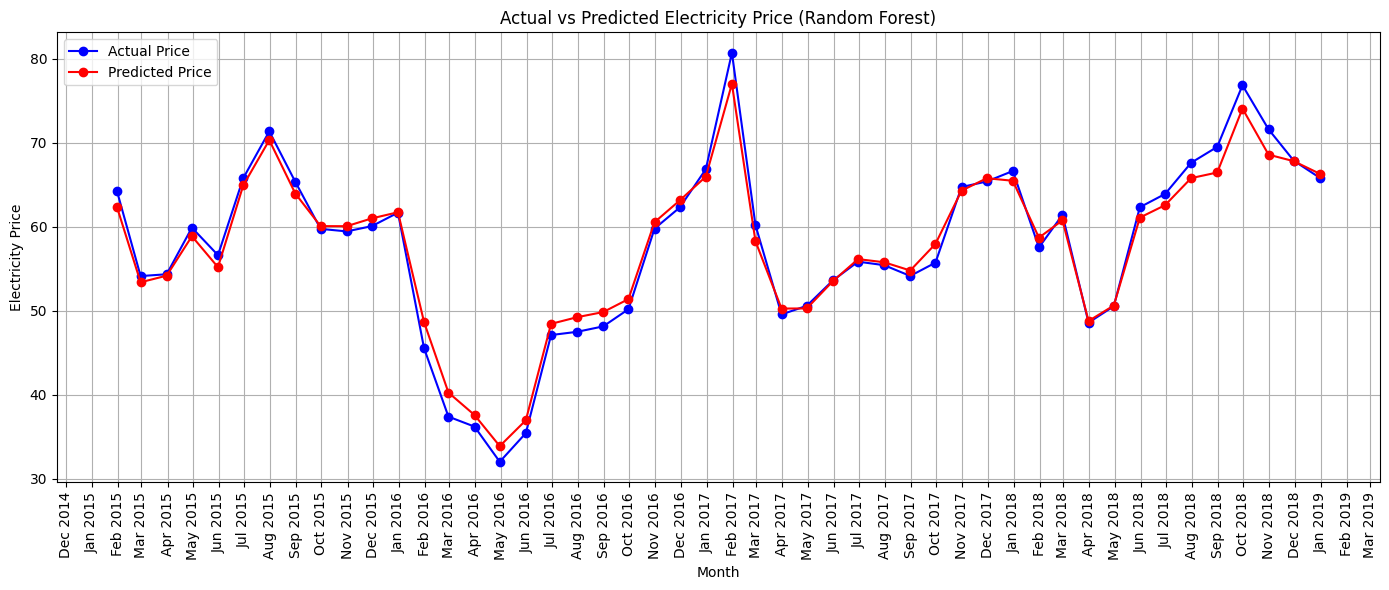

In [44]:
# Get the corresponding dates for the test set
test_indices_p = X_test_p.index

# Get the corresponding dates for the test set
test_dates_p = merged_dataset.loc[test_indices_p, 'time']

# Convert test_dates to datetime if not already
test_dates_p = pd.to_datetime(test_dates_p)

# Create a DataFrame with the dates, actual, and predicted values
results_df_p = pd.DataFrame({'Date': test_dates_p, 'Actual Price': y_test_p, 'Predicted Price': y_pred_rf_p})

# Set Date as the index
results_df_p.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_p = results_df_p.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results_p.index, monthly_results_p['Actual Price'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_p.index, monthly_results_p['Predicted Price'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price (Random Forest)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# RANDOM FOREST FOR PRICE WITH TUNING

In [45]:
# Initialize the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200,500],
    'max_depth': [5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Train the model with RandomizedSearchCV
random_search.fit(X_train_scaled_p, y_train_p)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Train the final model with the best parameters
best_rf_model_tun_p = random_search.best_estimator_
best_rf_model_tun_p.fit(X_train_scaled_p, y_train_p)

# Make predictions
y_pred_rf_tun_p = best_rf_model_tun_p.predict(X_test_scaled_p)

# Calculate metrics
mse_rf_tun_p = mean_squared_error(y_test_p, y_pred_rf_tun_p)
rmse_rf_tun_p = np.sqrt(mse_rf_tun_p)
mae_rf_tun_p = mean_absolute_error(y_test_p, y_pred_rf_tun_p)
r2_rf_tun_p = r2_score(y_test_p, y_pred_rf_tun_p)
mape_rf_tun_p = mean_absolute_percentage_error(y_test_p, y_pred_rf_tun_p)

# Calculate adjusted R-squared
n = X_test_p.shape[0]
p = X_test_p.shape[1]
adjusted_r2_rf_tun_p = 1 - ((1 - r2_rf_tun_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Random Forest Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_tun_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_tun_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_tun_p:.2f}')
print(f'R-squared (R²): {r2_rf_tun_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_tun_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_tun_p:.2f}%')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Tuned Random Forest Model for `price actual`:
Mean Squared Error (MSE): 22.45
Root Mean Squared Error (RMSE): 4.74
Mean Absolute Error (MAE): 3.23
R-squared (R²): 0.89
Adjusted R-squared: 0.89
Mean Absolute Percentage Error (MAPE): 0.07%


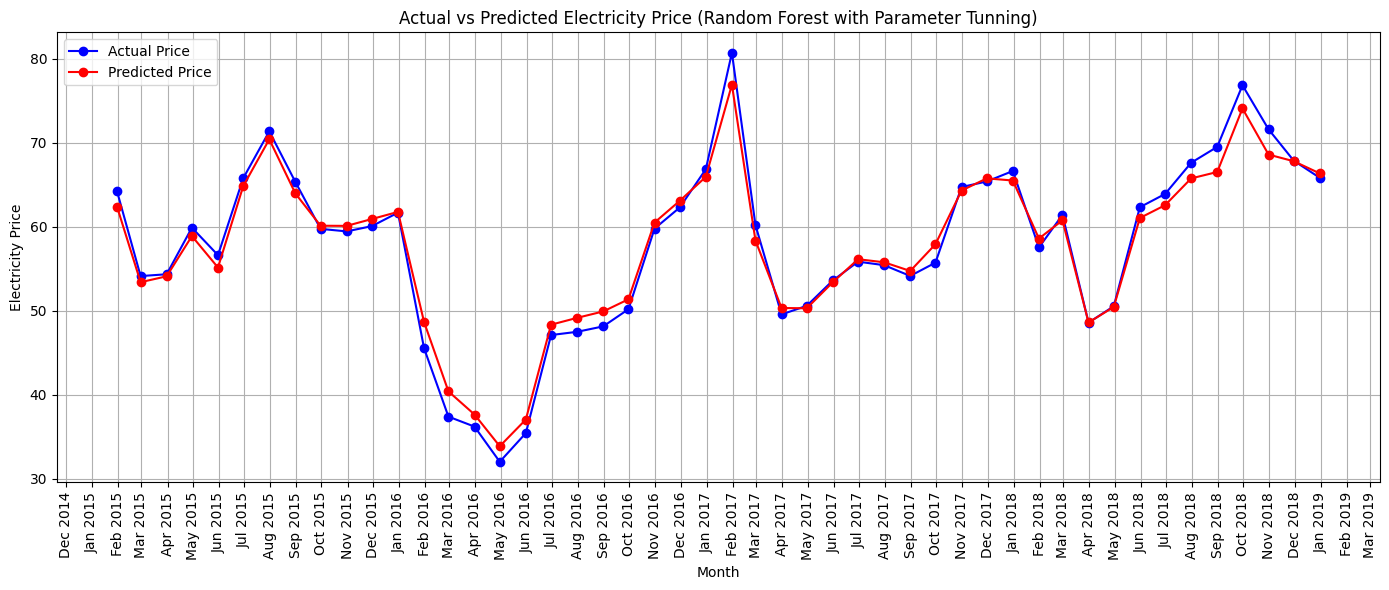

In [47]:
# Get the corresponding dates for the test set
test_indices_p = X_test_p.index

# Get the corresponding dates for the test set
test_dates_p = merged_dataset.loc[test_indices_p, 'time']

# Convert test_dates to datetime if not already
test_dates_p = pd.to_datetime(test_dates_p)

# Create a DataFrame with the dates, actual, and predicted values
results_df_p = pd.DataFrame({'Date': test_dates_p, 'Actual Price': y_test_p, 'Predicted Price': y_pred_rf_tun_p})

# Set Date as the index
results_df_p.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_p = results_df_p.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results_p.index, monthly_results_p['Actual Price'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_p.index, monthly_results_p['Predicted Price'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price (Random Forest with Parameter Tunning)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# RANDOM FOREST FOR LOAD WITH TUNING

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
rf_model = RandomForestRegressor(random_state=42)
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_dist = {
      'n_estimators': [50, 100], # Use a list to define a range of values for n_estimators
      'max_depth': [5,7,None],
      'min_samples_split': [2, 5], # Use a list to define a range of values for min_samples_split
      'min_samples_leaf': [1, 2], # Same issue here.
      'max_features': ['auto', 'sqrt']
  }

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Train the model with RandomizedSearchCV
random_search.fit(X_train_scaled_l, y_train_l)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Train the final model with the best parameters
best_rf_model_tun_l = random_search.best_estimator_
best_rf_model_tun_l.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_rf_tun_l = best_rf_model_tun_l.predict(X_test_scaled_l)

# Calculate metrics
mse_rf_tun_l = mean_squared_error(y_test_l, y_pred_rf_tun_l)
rmse_rf_tun_l = np.sqrt(mse_rf_tun_l)
mae_rf_tun_l = mean_absolute_error(y_test_l, y_pred_rf_tun_l)
r2_rf_tun_l = r2_score(y_test_l, y_pred_rf_tun_l)
mape_rf_tun_l = mean_absolute_percentage_error(y_test_l, y_pred_rf_tun_l)
# Calculate adjusted R-squared
n = X_test_l.shape[0]
p = X_test_l.shape[1]
adjusted_r2_rf_tun_l = 1 - ((1 - r2_rf_tun_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Random Forest Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_tun_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_tun_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_tun_l:.2f}')
print(f'R-squared (R²): {r2_rf_tun_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_tun_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_tun_l:.2f}%')

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

Tuned Random Forest Model for `total load actual`:
Mean Squared Error (MSE): 1011537.85
Root Mean Squared Error (RMSE): 1005.75
Mean Absolute Error (MAE): 756.80
R-squared (R²): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 0.03%


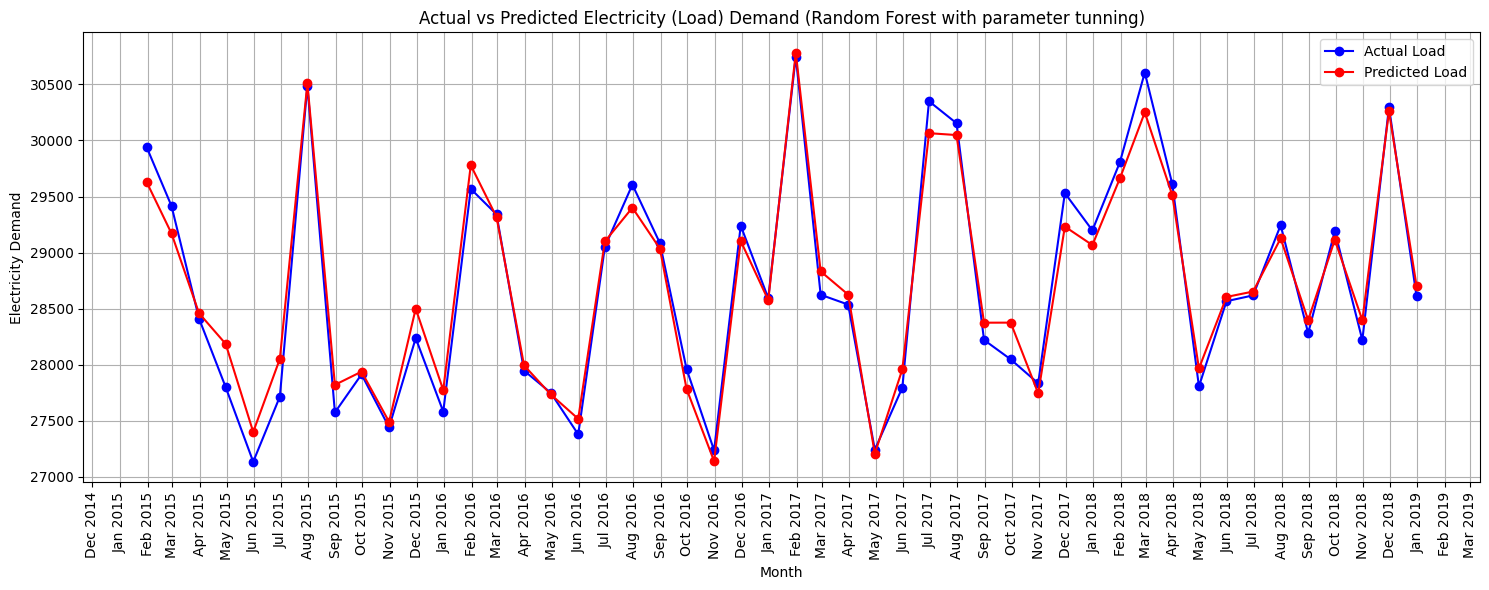

In [52]:
# Get the corresponding dates for the test set
test_indices = X_test_l.index

# Get the corresponding dates for the test set
test_dates = merged_dataset.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual Load': y_test_l, 'Predicted Load': y_pred_rf_tun_l})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(monthly_results.index, monthly_results['Actual Load'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted Load'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity (Load) Demand (Random Forest with parameter tunning)')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# GRADIENT BOOSTING FOR LOAD WITH PARAMETER TUNING

In [53]:
# Define the parameter grid for Gradient Boosting
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [ 0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5,],
    'min_samples_leaf': [1, 2,],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Gradient Boosting model
model_gb_tuned = GradientBoostingRegressor(random_state=42)

# Set up the GridSearchCV
grid_search_gb = GridSearchCV(estimator=model_gb_tuned, param_grid=param_grid_gb, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=2)

# Fit the GridSearchCV
grid_search_gb.fit(X_train_scaled_l, y_train_l)

# Print the best parameters and score
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"Best Score: {grid_search_gb.best_score_}")

# Train the model with the best parameters
best_gb_model_tun_l = grid_search_gb.best_estimator_
best_gb_model_tun_l.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_best_gb_tun_l = best_gb_model_tun_l.predict(X_test_scaled_l)

# Calculate metrics
mse_best_gb_tun_l = mean_squared_error(y_test_l, y_pred_best_gb_tun_l)
rmse_best_gb_tun_l = np.sqrt(mse_best_gb_tun_l)
mae_best_gb_tun_l = mean_absolute_error(y_test_l, y_pred_best_gb_tun_l)
r2_best_gb_tun_l = r2_score(y_test_l, y_pred_best_gb_tun_l)
mape_best_gb_tun_l = mean_absolute_percentage_error(y_test_l, y_pred_best_gb_tun_l)

# Calculate adjusted R-squared
n = X_test_scaled_l.shape[0]
p = X_test_scaled_l.shape[1]
adjusted_r2_best_gb_tun_l = 1 - ((1 - r2_best_gb_tun_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Gradient Boosting Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_best_gb_tun_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_best_gb_tun_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_best_gb_tun_l:.2f}')
print(f'R-squared (R²): {r2_best_gb_tun_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_best_gb_tun_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_best_gb_tun_l:.2f}%')

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -0.030272853304843833


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di


Tuned Gradient Boosting Model for `total load actual`:
Mean Squared Error (MSE): 1187247.07
Root Mean Squared Error (RMSE): 1089.61
Mean Absolute Error (MAE): 840.19
R-squared (R²): 0.94
Adjusted R-squared: 0.94
Mean Absolute Percentage Error (MAPE): 0.03%


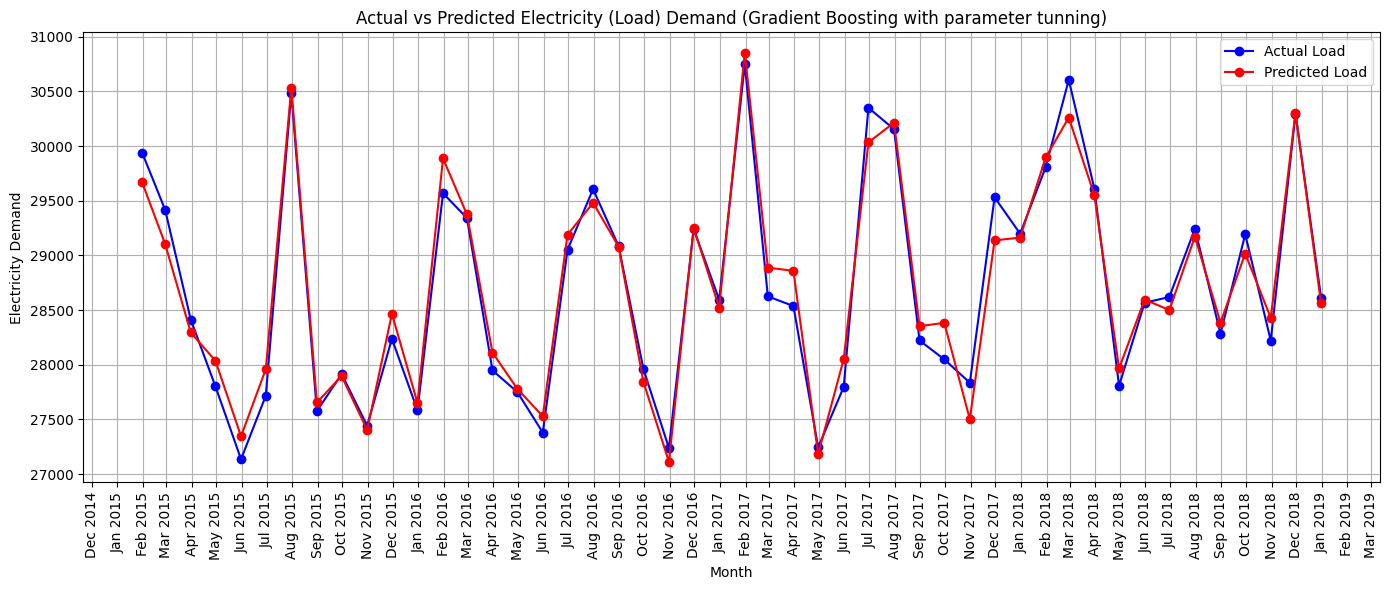

In [54]:
# Get the corresponding dates for the test set
test_indices = X_test_l.index

# Get the corresponding dates for the test set
test_dates = merged_dataset.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual Load': y_test_l, 'Predicted Load': y_pred_best_gb_tun_l})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual Load'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted Load'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity (Load) Demand (Gradient Boosting with parameter tunning)')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
 # GRADIENT BOOSTING FOR PRICE WITH TUNING

In [55]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [ 0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Gradient Boosting model
model_gb_tuned = GradientBoostingRegressor(random_state=42)

# Set up the GridSearchCV
grid_search_gb = GridSearchCV(estimator=model_gb_tuned, param_grid=param_grid_gb, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=2)

# Fit the GridSearchCV
grid_search_gb.fit(X_train_scaled_p, y_train_p)

# Print the best parameters and score
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"Best Score: {grid_search_gb.best_score_}")

# Train the model with the best parameters
best_gb_model_tun_p = grid_search_gb.best_estimator_
best_gb_model_tun_p.fit(X_train_scaled_p, y_train_p)

# Make predictions
y_pred_best_gb_tun_p = best_gb_model_tun_p.predict(X_test_scaled_p)

# Calculate metrics
mse_best_gb_tun_p = mean_squared_error(y_test_p, y_pred_best_gb_tun_p)
rmse_best_gb_tun_p = np.sqrt(mse_best_gb_tun_p)
mae_best_gb_tun_p = mean_absolute_error(y_test_p, y_pred_best_gb_tun_p)
r2_best_gb_tun_p = r2_score(y_test_p, y_pred_best_gb_tun_p)
mape_best_gb_tun_p = mean_absolute_percentage_error(y_test_p, y_pred_best_gb_tun_p)

# Calculate adjusted R-squared
n = X_test_p.shape[0]
p = X_test_p.shape[1]
adjusted_r2_best_gb_tun_p = 1 - ((1 - r2_best_gb_tun_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Gradient Boosting Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_best_gb_tun_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_best_gb_tun_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_best_gb_tun_p:.2f}')
print(f'R-squared (R²): {r2_best_gb_tun_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_best_gb_tun_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_best_gb_tun_p:.2f}%')

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: -0.0938678381285765


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di


Tuned Gradient Boosting Model for `price actual`:
Mean Squared Error (MSE): 38.94
Root Mean Squared Error (RMSE): 6.24
Mean Absolute Error (MAE): 4.62
R-squared (R²): 0.81
Adjusted R-squared: 0.81
Mean Absolute Percentage Error (MAPE): 0.09%


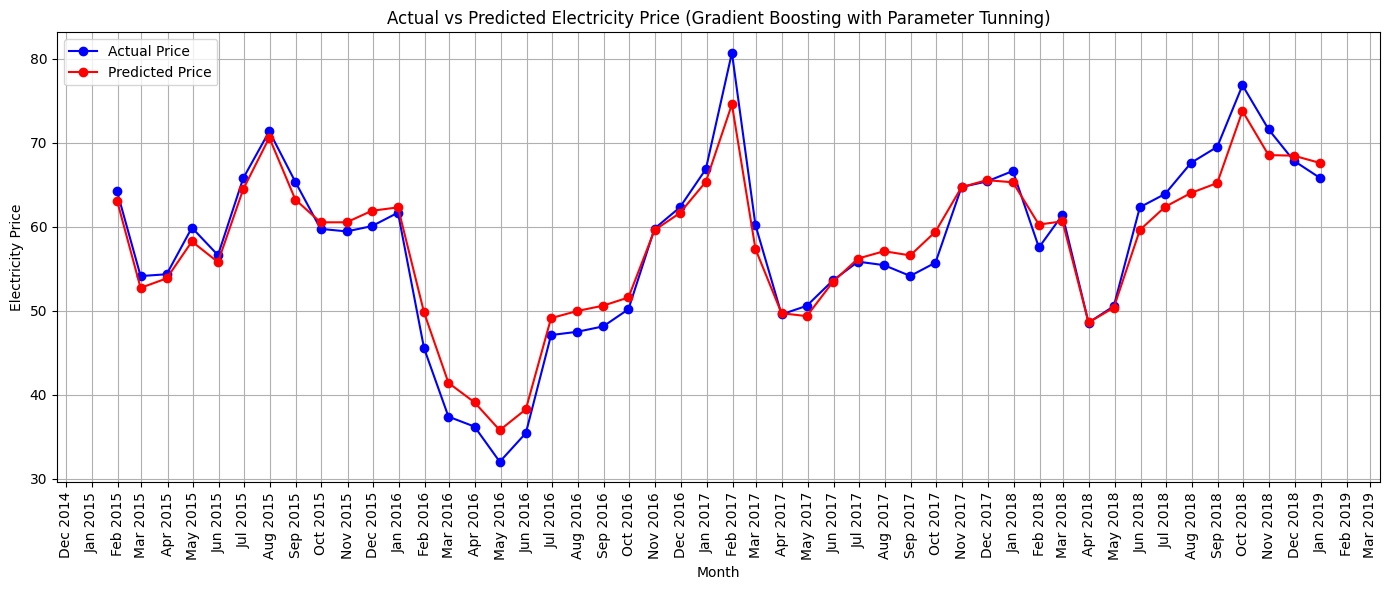

In [57]:
# Get the corresponding dates for the test set
test_indices_p = X_test_p.index

# Get the corresponding dates for the test set
test_dates_p = merged_dataset.loc[test_indices_p, 'time']

# Convert test_dates to datetime if not already
test_dates_p = pd.to_datetime(test_dates_p)

# Create a DataFrame with the dates, actual, and predicted values
results_df_p = pd.DataFrame({'Date': test_dates_p, 'Actual Price': y_test_p, 'Predicted Price': y_pred_best_gb_tun_p})

# Set Date as the index
results_df_p.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_p = results_df_p.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results_p.index, monthly_results_p['Actual Price'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_p.index, monthly_results_p['Predicted Price'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price (Gradient Boosting with Parameter Tunning)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# LSTM MODEL FOR PRICE

In [60]:
# Reshape the data to fit the LSTM model (samples, timesteps, features)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
timesteps = 1
X_train_scaled_p = X_train_scaled_p.reshape((X_train_scaled_p.shape[0], timesteps, X_train_scaled_p.shape[2]))
X_test_scaled_p = X_test_scaled_p.reshape((X_test_scaled_p.shape[0], timesteps, X_test_scaled_p.shape[2]))

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(timesteps, X_train_scaled_p.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled_p, y_train_p, epochs=250, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_lstm_p = model.predict(X_test_scaled_p).flatten()

# Calculate metrics
mse_lstm_p = mean_squared_error(y_test_p, y_pred_lstm_p)
rmse_lstm_p = np.sqrt(mse_lstm_p)
mae_lstm_p = mean_absolute_error(y_test_p, y_pred_lstm_p)
r2_lstm_p = r2_score(y_test_p, y_pred_lstm_p)
mape_lstm_p = np.mean(np.abs((y_test_p - y_pred_lstm_p) / y_test_p)) * 100

# Calculate adjusted R-squared
n = X_test_scaled_p.shape[0]
p = X_test_scaled_p.shape[2]
adjusted_r2_lstm_p = 1 - ((1 - r2_lstm_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nLSTM Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_lstm_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lstm_p:.2f}')
print(f'R-squared (R²): {r2_lstm_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lstm_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lstm_p:.2f}%')

Epoch 1/250
702/702 [==============================] - 13s 8ms/step - loss: 665.5370 - val_loss: 112.7963
Epoch 2/250
702/702 [==============================] - 7s 10ms/step - loss: 151.4991 - val_loss: 87.1913
Epoch 3/250
702/702 [==============================] - 6s 8ms/step - loss: 131.4157 - val_loss: 78.0827
Epoch 4/250
702/702 [==============================] - 7s 11ms/step - loss: 124.1540 - val_loss: 73.8081
Epoch 5/250
702/702 [==============================] - 5s 7ms/step - loss: 119.9808 - val_loss: 74.1223
Epoch 6/250
702/702 [==============================] - 6s 9ms/step - loss: 114.6073 - val_loss: 72.0912
Epoch 7/250
702/702 [==============================] - 6s 8ms/step - loss: 112.9548 - val_loss: 68.2241
Epoch 8/250
702/702 [==============================] - 5s 8ms/step - loss: 111.4163 - val_loss: 68.0794
Epoch 9/250
702/702 [==============================] - 7s 10ms/step - loss: 109.6404 - val_loss: 63.8325
Epoch 10/250
702/702 [==============================] - 6s 

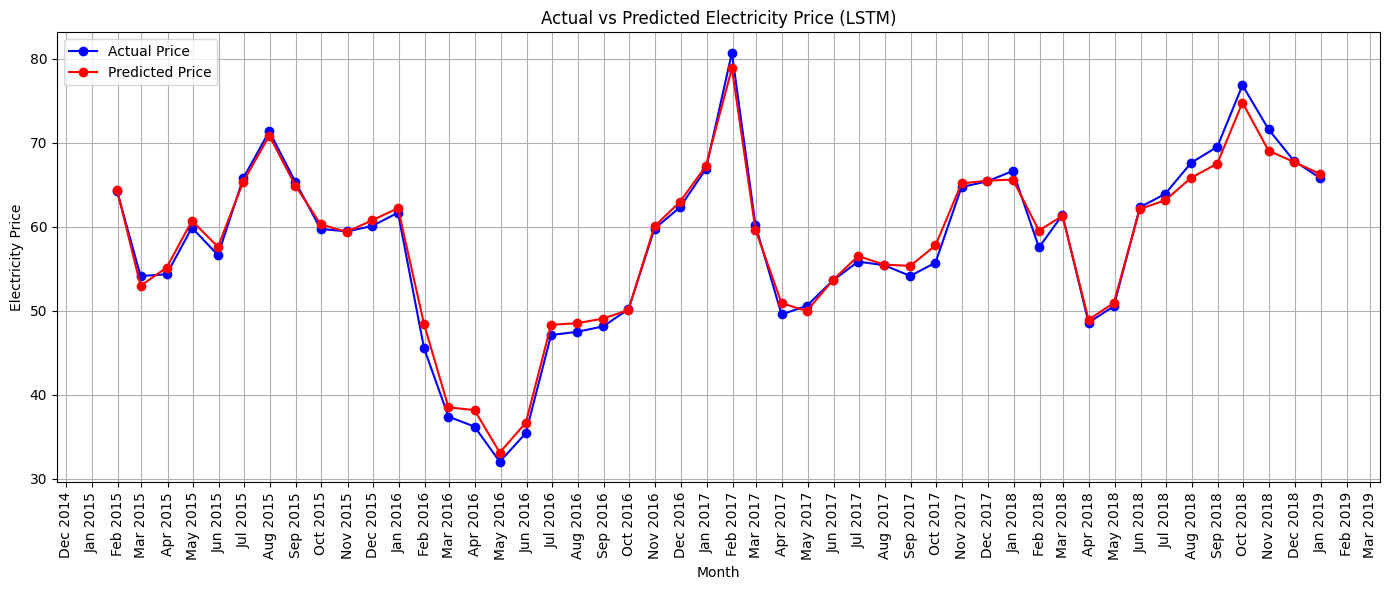

In [61]:
# Get the corresponding dates for the test set
test_indices_p = X_test_p.index

# Get the corresponding dates for the test set
test_dates_p = merged_dataset.loc[test_indices_p, 'time']

# Convert test_dates to datetime if not already
test_dates_p = pd.to_datetime(test_dates_p)

# Create a DataFrame with the dates, actual, and predicted values
results_df_p = pd.DataFrame({'Date': test_dates_p, 'Actual Price': y_test_p, 'Predicted Price': y_pred_lstm_p})

# Set Date as the index
results_df_p.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_p = results_df_p.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results_p.index, monthly_results_p['Actual Price'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_p.index, monthly_results_p['Predicted Price'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price (LSTM)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# FOR LOAD

In [62]:
# Check the shapes
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from keras.callbacks import EarlyStopping

# Reshape the data to fit the LSTM model (samples, timesteps, features)
timesteps = 1  # Adjust this value based on your problem
X_train_scaled_l = X_train_scaled_l.reshape((X_train_scaled_l.shape[0], timesteps, X_train_scaled_l.shape[1]))
X_test_scaled_l = X_test_scaled_l.reshape((X_test_scaled_l.shape[0], timesteps, X_test_scaled_l.shape[1]))

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_scaled_l.shape[1], X_train_scaled_l.shape[2]), return_sequences=True)) # Now X_train_scaled_l.shape[2] exists
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled_l, y_train_l, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_lstm_l = model.predict(X_test_scaled_l).flatten()

# Calculate metrics
mse_lstm_l = mean_squared_error(y_test_l, y_pred_lstm_l)
rmse_lstm_l = np.sqrt(mse_lstm_l)
mae_lstm_l = mean_absolute_error(y_test_l, y_pred_lstm_l)
r2_lstm_l = r2_score(y_test_l, y_pred_lstm_l)
mape_lstm_l = mean_absolute_percentage_error(y_test_l, y_pred_lstm_l)

# Calculate adjusted R-squared
n = X_test_scaled_l.shape[0]
p = X_test_scaled_l.shape[2]
adjusted_r2_lstm_l = 1 - ((1 - r2_lstm_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nLSTM Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_lstm_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lstm_l:.2f}')
print(f'R-squared (R²): {r2_lstm_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lstm_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lstm_l:.2f}%')

Epoch 1/50
702/702 [==============================] - 10s 10ms/step - loss: 619710208.0000 - val_loss: 209179728.0000
Epoch 2/50
702/702 [==============================] - 5s 7ms/step - loss: 122222072.0000 - val_loss: 68710840.0000
Epoch 3/50
702/702 [==============================] - 7s 9ms/step - loss: 58894284.0000 - val_loss: 31706958.0000
Epoch 4/50
702/702 [==============================] - 6s 9ms/step - loss: 36532996.0000 - val_loss: 18071960.0000
Epoch 5/50
702/702 [==============================] - 7s 9ms/step - loss: 27046082.0000 - val_loss: 11665968.0000
Epoch 6/50
702/702 [==============================] - 5s 7ms/step - loss: 22322440.0000 - val_loss: 8564160.0000
Epoch 7/50
702/702 [==============================] - 6s 9ms/step - loss: 19595300.0000 - val_loss: 6743309.5000
Epoch 8/50
702/702 [==============================] - 5s 7ms/step - loss: 18239632.0000 - val_loss: 5591101.5000
Epoch 9/50
702/702 [==============================] - 7s 10ms/step - loss: 17027426.00

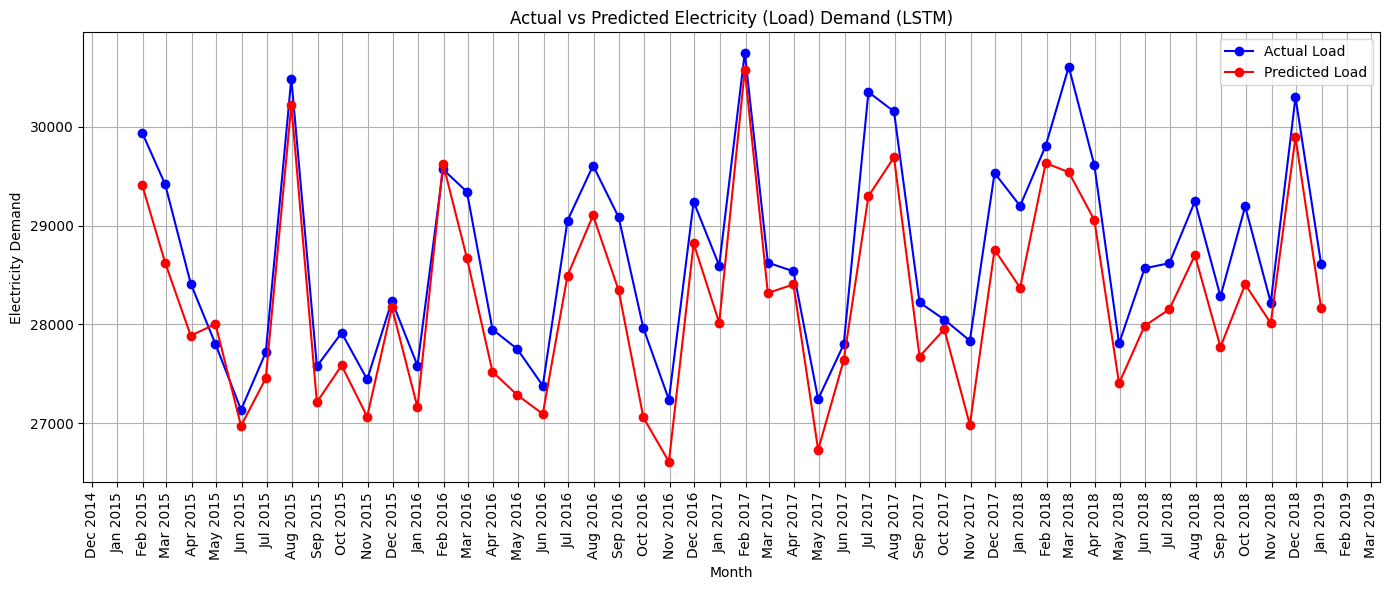

In [63]:
# Get the corresponding dates for the test set
test_indices = X_test_l.index

# Get the corresponding dates for the test set
test_dates = merged_dataset.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual Load': y_test_l, 'Predicted Load': y_pred_lstm_l})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual Load'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted Load'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity (Load) Demand (LSTM)')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45

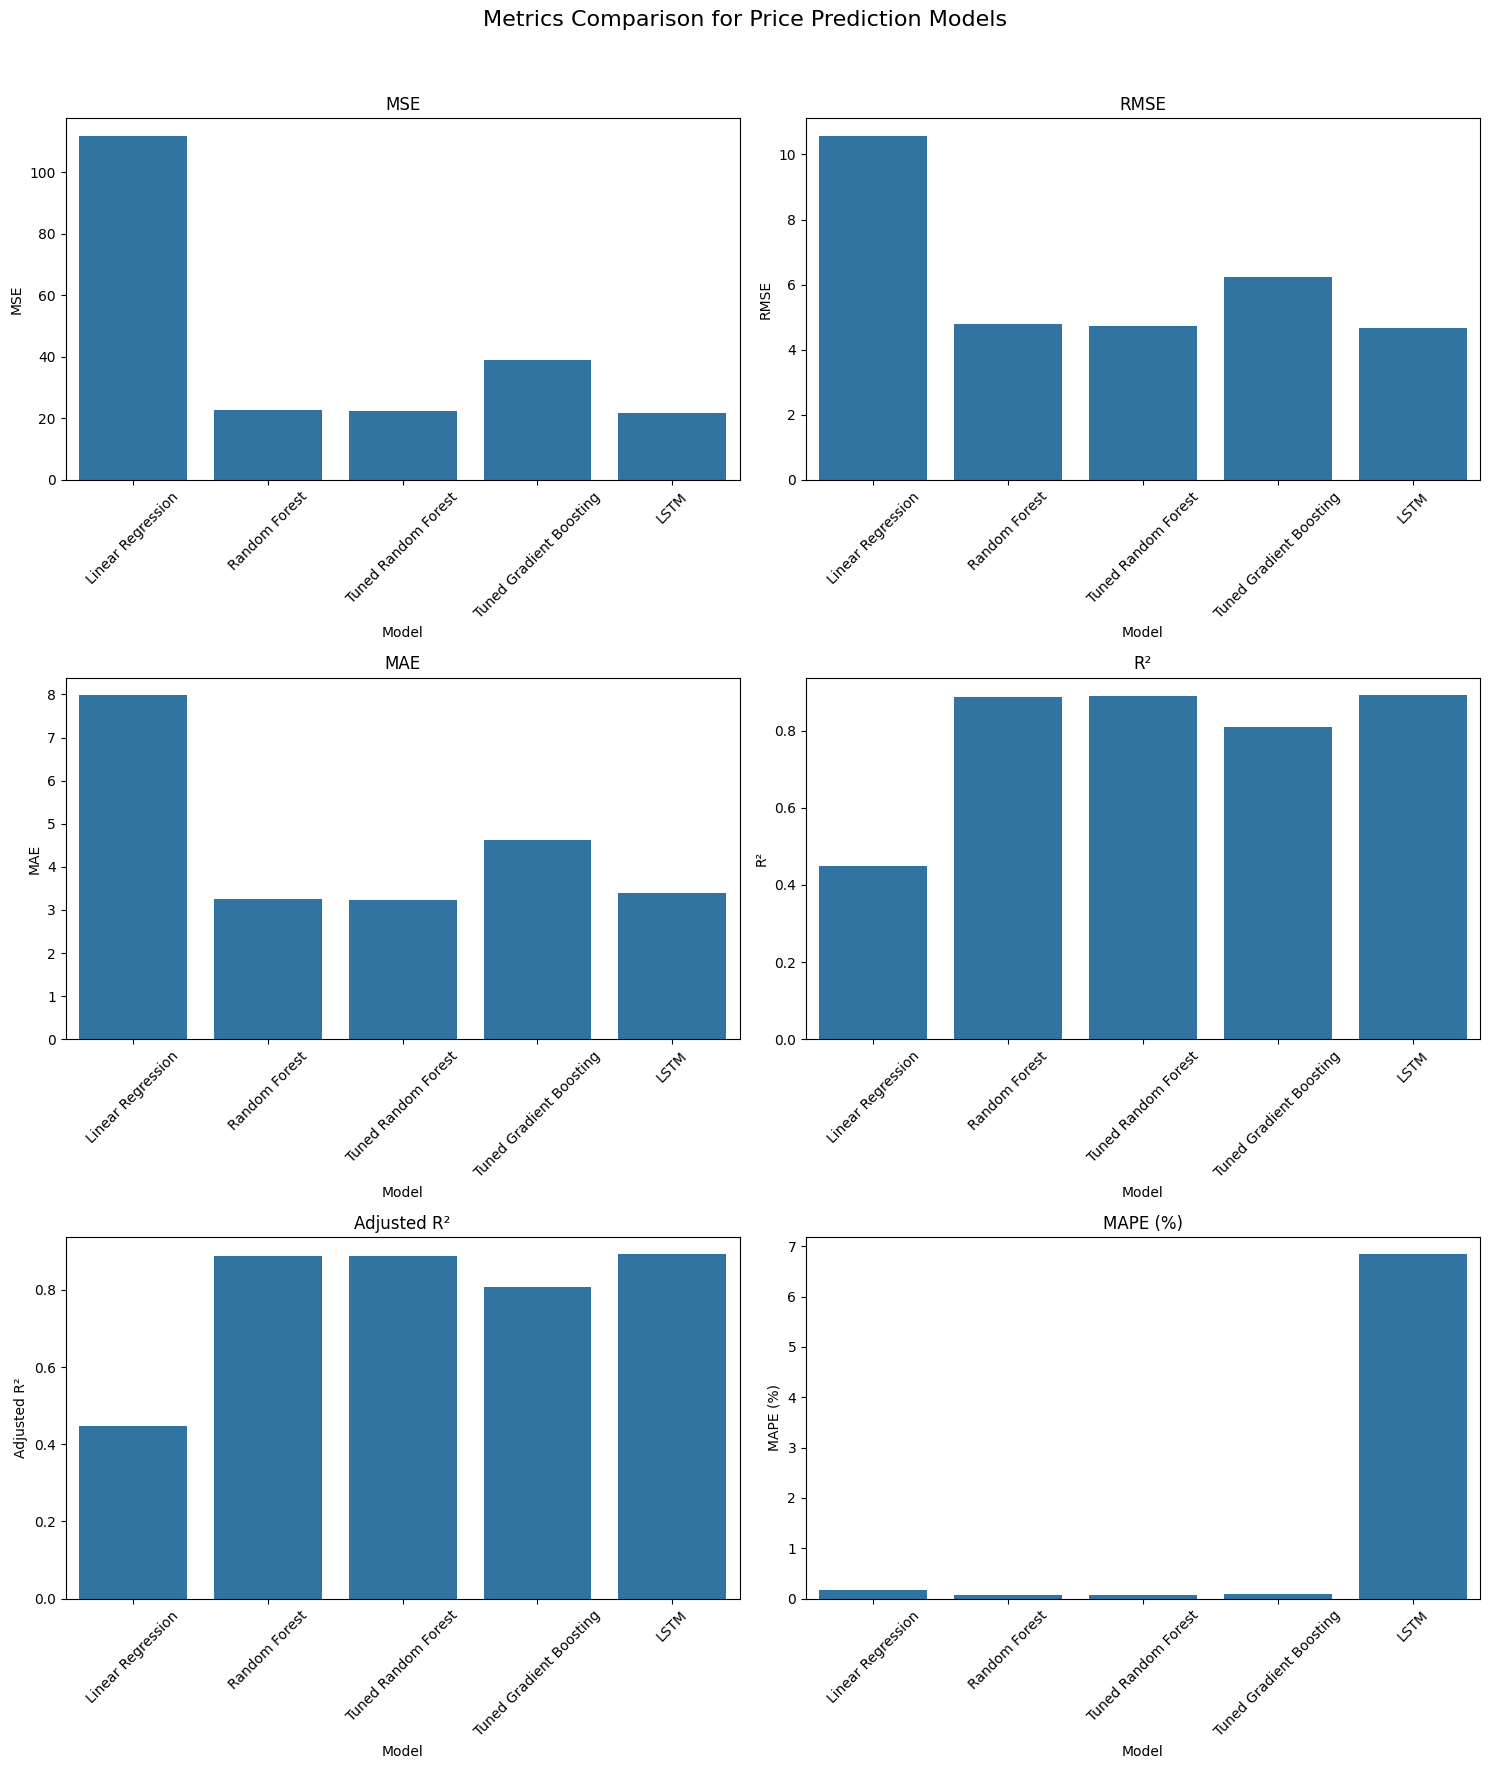

<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-67-de50abf9dc70>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45

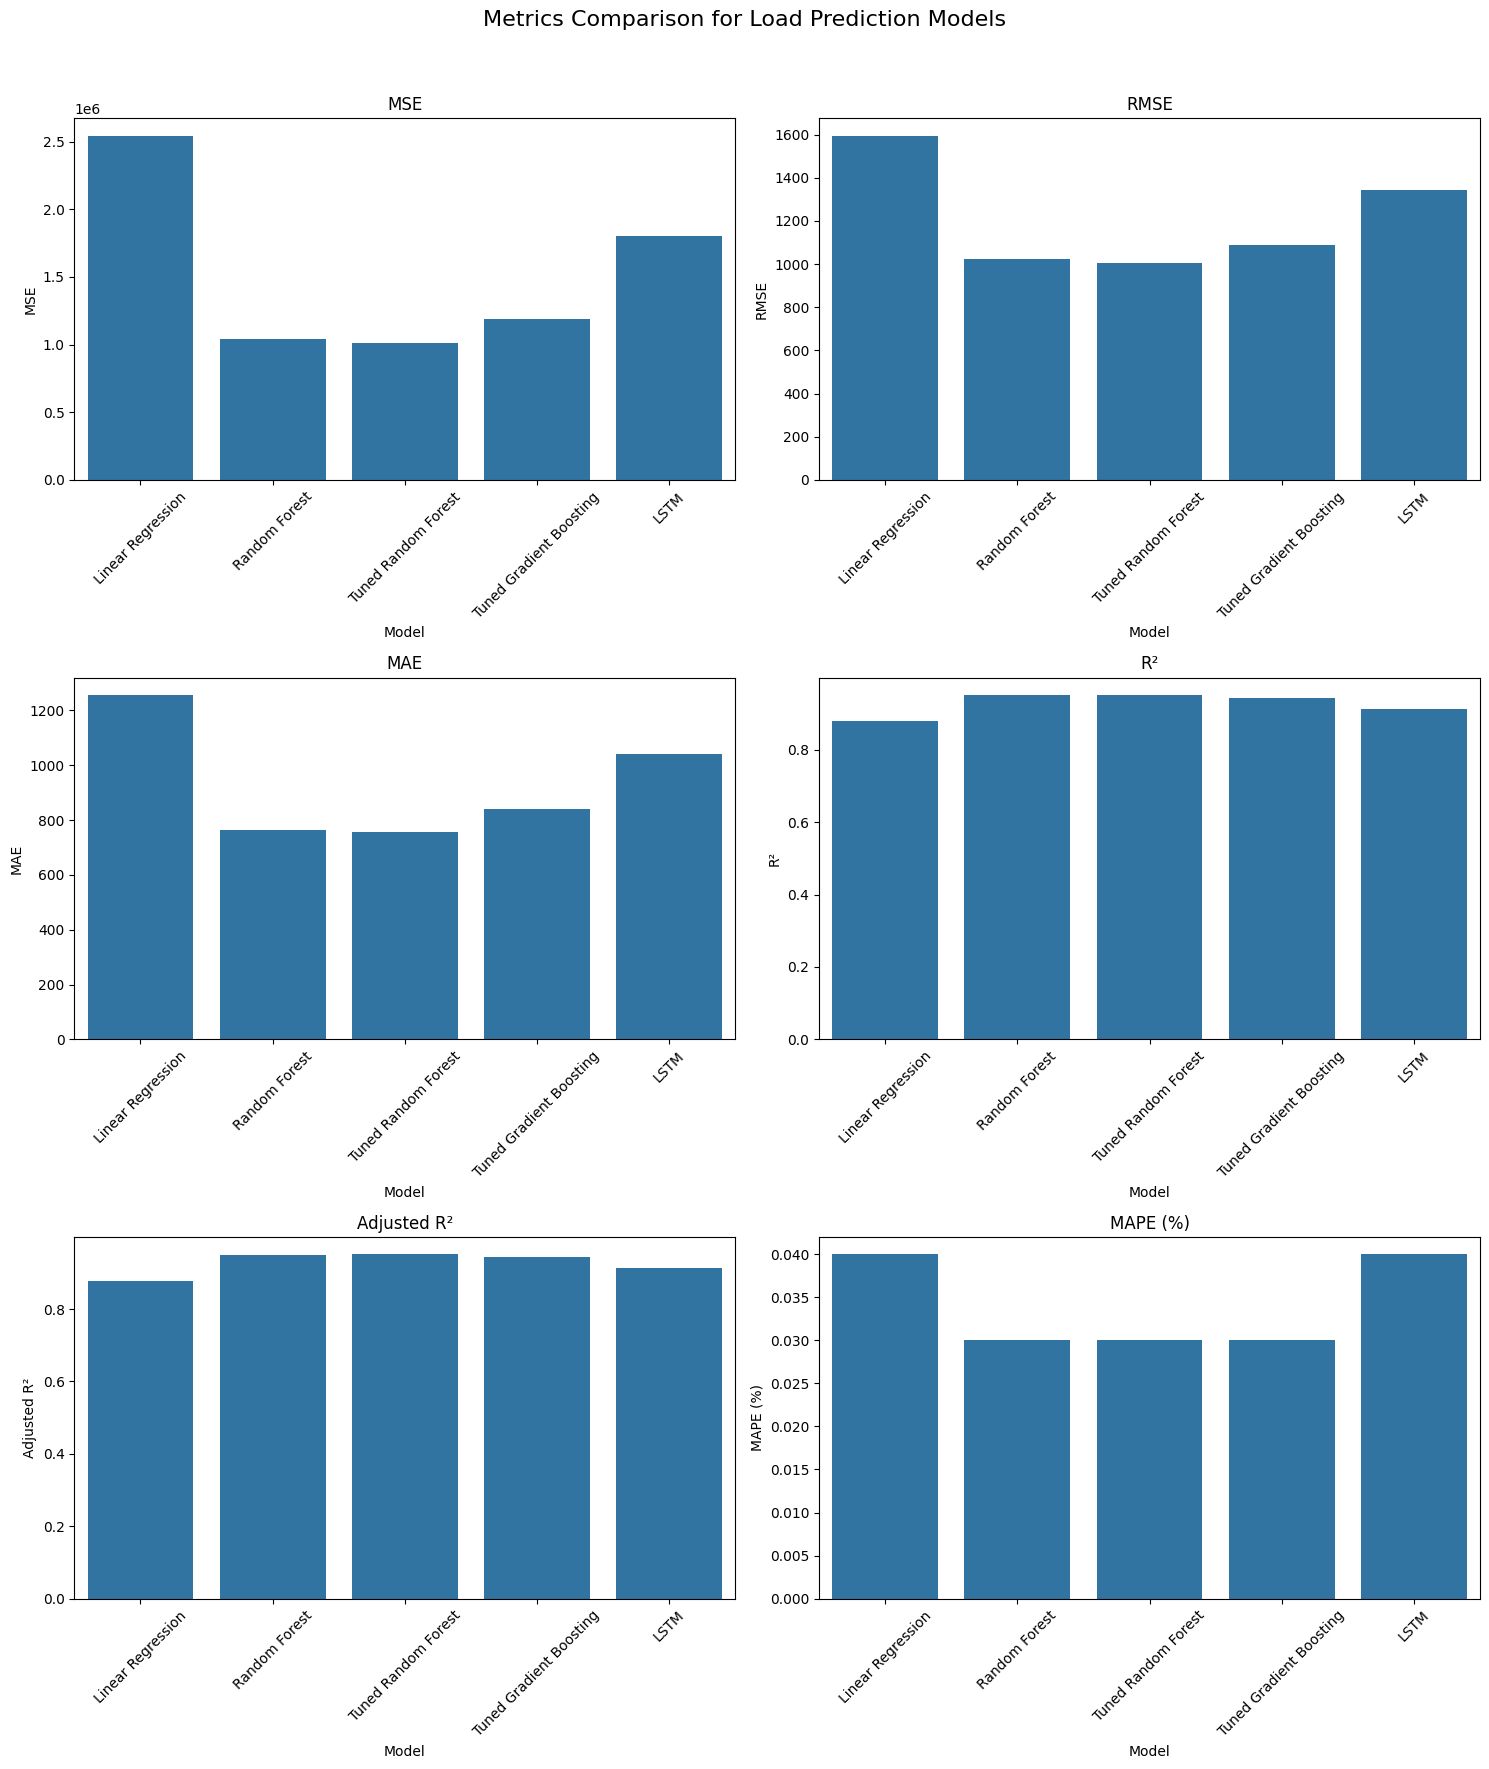

In [67]:
# Round function for MAPE values to two decimal places
def round_mape(mape):
    return round(mape, 2)

# Define the metrics for price prediction
price_metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Tuned Random Forest',  'Tuned Gradient Boosting', 'LSTM'],
    'MSE': [mse_lr_p, mse_rf_p, mse_rf_tun_p,  mse_best_gb_tun_p, mse_lstm_p],
    'RMSE': [rmse_lr_p, rmse_rf_p, rmse_rf_tun_p,  rmse_best_gb_tun_p, rmse_lstm_p],
    'MAE': [mae_lr_p, mae_rf_p, mae_rf_tun_p,  mae_best_gb_tun_p, mae_lstm_p],
    'R²': [r2_lr_p, r2_rf_p, r2_rf_tun_p,  r2_best_gb_tun_p, r2_lstm_p],
    'Adjusted R²': [adjusted_r2_lr_p, adjusted_r2_rf_p, adjusted_r2_rf_tun_p,  adjusted_r2_best_gb_tun_p, adjusted_r2_lstm_p],
    'MAPE (%)': [mape_lr_p, mape_rf_p, mape_rf_tun_p,  mape_best_gb_tun_p, mape_lstm_p]
}

# Define the metrics for total load actual prediction
load_metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Tuned Random Forest', 'Tuned Gradient Boosting', 'LSTM'],
    'MSE': [mse_lr_l, mse_rf_l, mse_rf_tun_l, mse_best_gb_tun_l, mse_lstm_l],
    'RMSE': [rmse_lr_l, rmse_rf_l, rmse_rf_tun_l,  rmse_best_gb_tun_l, rmse_lstm_l],
    'MAE': [mae_lr_l, mae_rf_l, mae_rf_tun_l,  mae_best_gb_tun_l, mae_lstm_l],
    'R²': [r2_lr_l, r2_rf_l, r2_rf_tun_l,  r2_best_gb_tun_l, r2_lstm_l],
    'Adjusted R²': [adjusted_r2_lr_l, adjusted_r2_rf_l, adjusted_r2_rf_tun_l,  adjusted_r2_best_gb_tun_l, adjusted_r2_lstm_l],
    'MAPE (%)': [mape_lr_l, mape_rf_l, mape_rf_tun_l,  mape_best_gb_tun_l, mape_lstm_l]
}

# Create dataframes
price_df = pd.DataFrame(price_metrics)
load_df = pd.DataFrame(load_metrics)

# Format MAPE values to two decimal places
price_df['MAPE (%)'] = price_df['MAPE (%)'].apply(round_mape)
load_df['MAPE (%)'] = load_df['MAPE (%)'].apply(round_mape)

# Plotting the metrics
def plot_metrics(df, title):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle(title, fontsize=16)
    metrics = ['MSE', 'RMSE', 'MAE', 'R²', 'Adjusted R²', 'MAPE (%)']

    for metric, ax in zip(metrics, axes.flatten()):
        sns.barplot(x='Model', y=metric, data=df, ax=ax)
        ax.set_title(metric)
        ax.set_xlabel('Model')
        ax.set_ylabel(metric)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot metrics for price prediction
plot_metrics(price_df, 'Metrics Comparison for Price Prediction Models')

# Plot metrics for load prediction
plot_metrics(load_df, 'Metrics Comparison for Load Prediction Models')

In [ ]:
# COMPARISON TABLE

In [68]:
# Display the tables
print("\nComparison Table for Price Prediction:")
display(price_df)

print("\nComparison Table for Load Prediction:")
display(load_df)


Comparison Table for Price Prediction:


,Model,MSE,RMSE,MAE,R²,Adjusted R²,MAPE (%)
0,Linear Regression,111.972803,10.581720,7.990224,0.448594,0.446621,0.17
1,Random Forest,22.885549,4.783884,3.261861,0.887301,0.886898,0.07
2,Tuned Random Forest,22.445813,4.737701,3.229189,0.889466,0.889071,0.07
3,Tuned Gradient Boosting,38.936097,6.239880,4.616388,0.808261,0.807575,0.09
4,LSTM,21.775255,4.666396,3.392206,0.892769,0.892385,6.84



Comparison Table for Load Prediction:


,Model,MSE,RMSE,MAE,R²,Adjusted R²,MAPE (%)
0,Linear Regression,2.544405e+06,1595.119224,1256.933887,0.878008,0.877624,0.04
1,Random Forest,1.043240e+06,1021.391089,762.391306,0.949982,0.949824,0.03
2,Tuned Random Forest,1.011538e+06,1005.752379,756.795617,0.951502,0.951349,0.03
3,Tuned Gradient Boosting,1.187247e+06,1089.608680,840.190613,0.943077,0.942898,0.03
4,LSTM,1.800804e+06,1341.940407,1042.044782,0.913660,0.913388,0.04


In [ ]:
# IMPORTANCE OF FEATURES

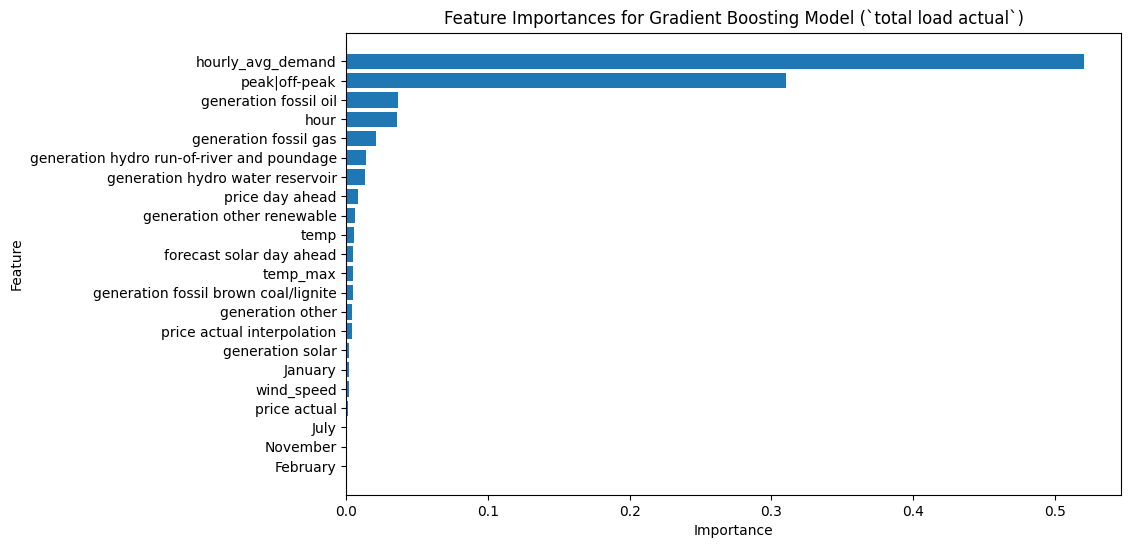

In [69]:
# Get feature importances
feature_importance_gb = best_gb_model_tun_l.feature_importances_

# Get feature names from your original dataset
feature_names_gb = X_l.columns

# Sort feature importances in descending order
indices_gb = np.argsort(feature_importance_gb)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names_gb[indices_gb], feature_importance_gb[indices_gb])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Gradient Boosting Model (`total load actual`)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

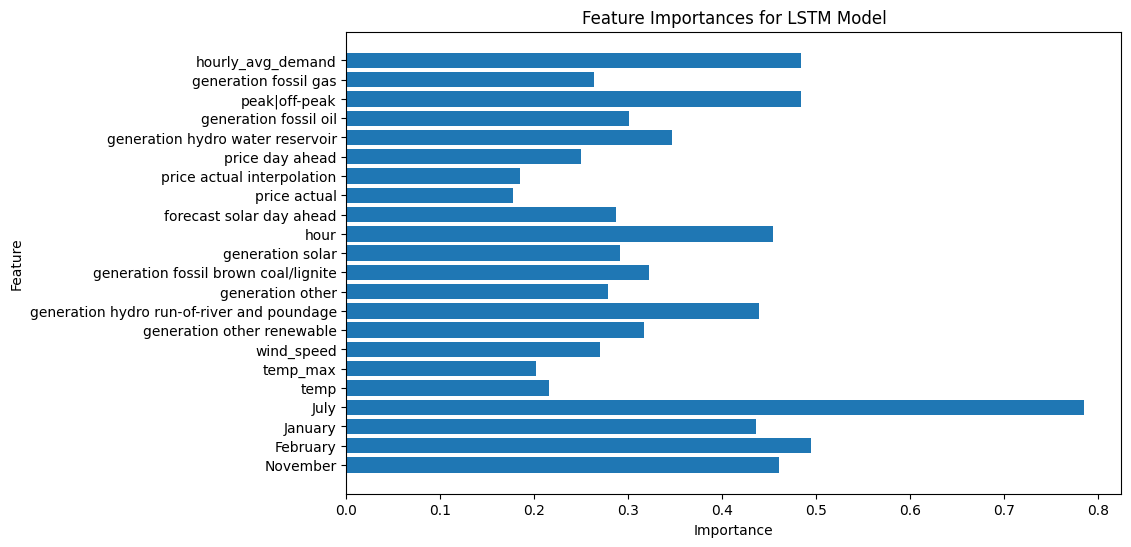

In [72]:
# Get the LSTM model layer weights
layer_weights = model.layers[0].get_weights()[0]  # Adjust index based on your model architecture

# Aggregate importance across timesteps and features
feature_importance = np.mean(np.abs(layer_weights), axis=1)

# Get feature names from your original dataset
# Ensure you are using the correct DataFrame for feature names (X_l in this case)
feature_names = X_l.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for LSTM Model')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

In [ ]:
#Monthly Actual vs Predicted Electricity (Load) Demand

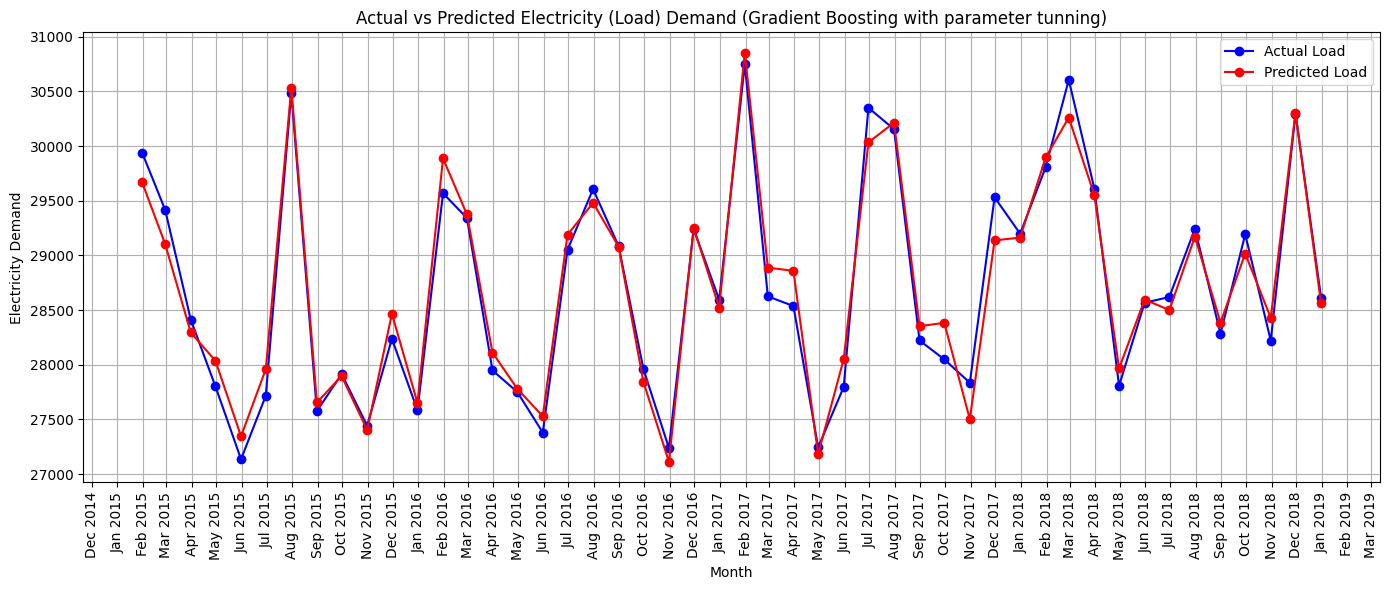

In [74]:
# Get the corresponding dates for the test set
test_indices = X_test_l.index

# Get the corresponding dates for the test set
test_dates = merged_dataset.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual Load': y_test_l, 'Predicted Load': y_pred_best_gb_tun_l})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual Load'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted Load'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity (Load) Demand (Gradient Boosting with parameter tunning)')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
#Monthly Actual vs Predicted Electricity Price

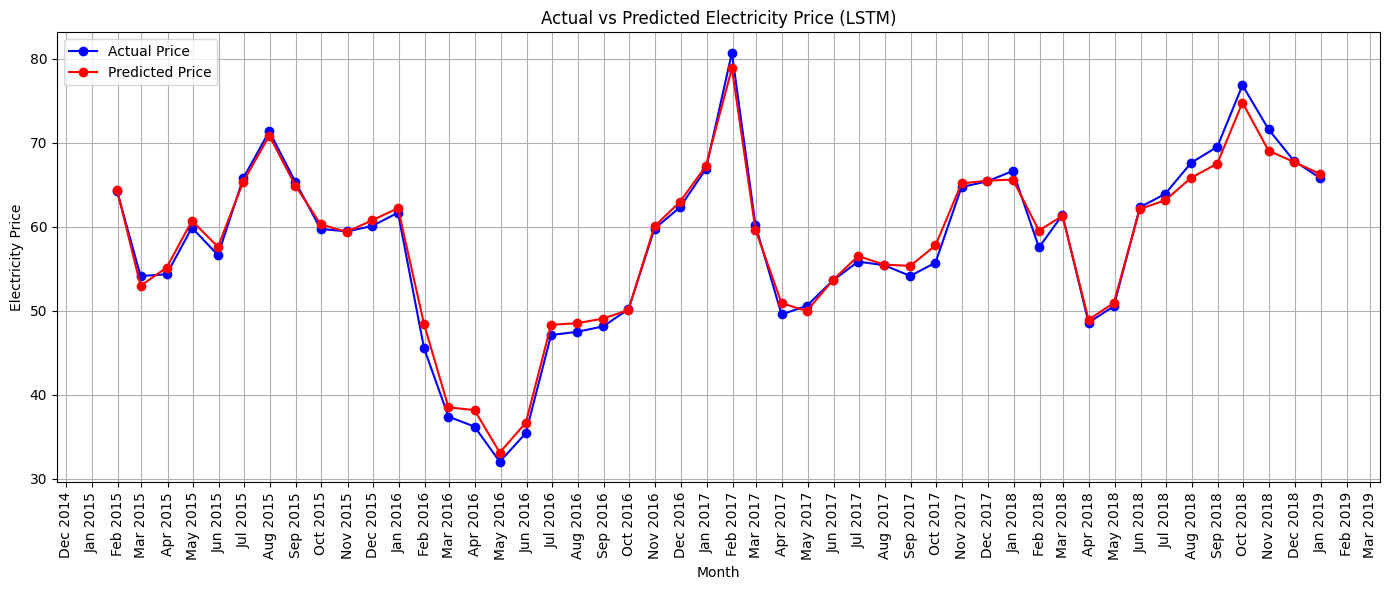

In [75]:
# Get the corresponding dates for the test set
test_indices_p = X_test_p.index

# Get the corresponding dates for the test set
test_dates_p = merged_dataset.loc[test_indices_p, 'time']

# Convert test_dates to datetime if not already
test_dates_p = pd.to_datetime(test_dates_p)

# Create a DataFrame with the dates, actual, and predicted values
results_df_p = pd.DataFrame({'Date': test_dates_p, 'Actual Price': y_test_p, 'Predicted Price': y_pred_lstm_p})

# Set Date as the index
results_df_p.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_p = results_df_p.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results_p.index, monthly_results_p['Actual Price'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_p.index, monthly_results_p['Predicted Price'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price (LSTM)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()